In [1]:
#%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import osmnx as ox, geopandas as gpd, pandas as pd, networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from IPython.display import Image
from descartes import PolygonPatch
from itertools import combinations, combinations_with_replacement
%matplotlib inline
ox.config(log_console=True, use_cache=True)
%config IPCompleter.greedy=True

import libpysal as lp

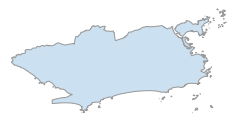

{'init': 'epsg:4326'}


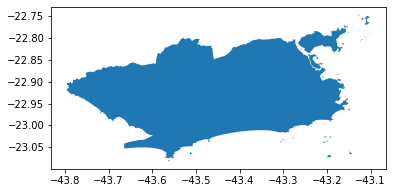

time: 3 s


In [2]:
city = ox.gdf_from_place('Rio de Janeiro, Brazil')
#city = ox.project_gdf(city)
fig, ax = ox.plot_shape(city, figsize=(4,4))
ox.save_gdf_shapefile(city)
crs = {'init': 'epsg:4326'}
city = city.to_crs(crs)
print(city.crs)
city.plot()

13395
data max index: 13394
number of NA prices: 0
average bedroom price 152.25945102451806
pointinpoly length: 13300
check contains: True
check if there are NAs: False


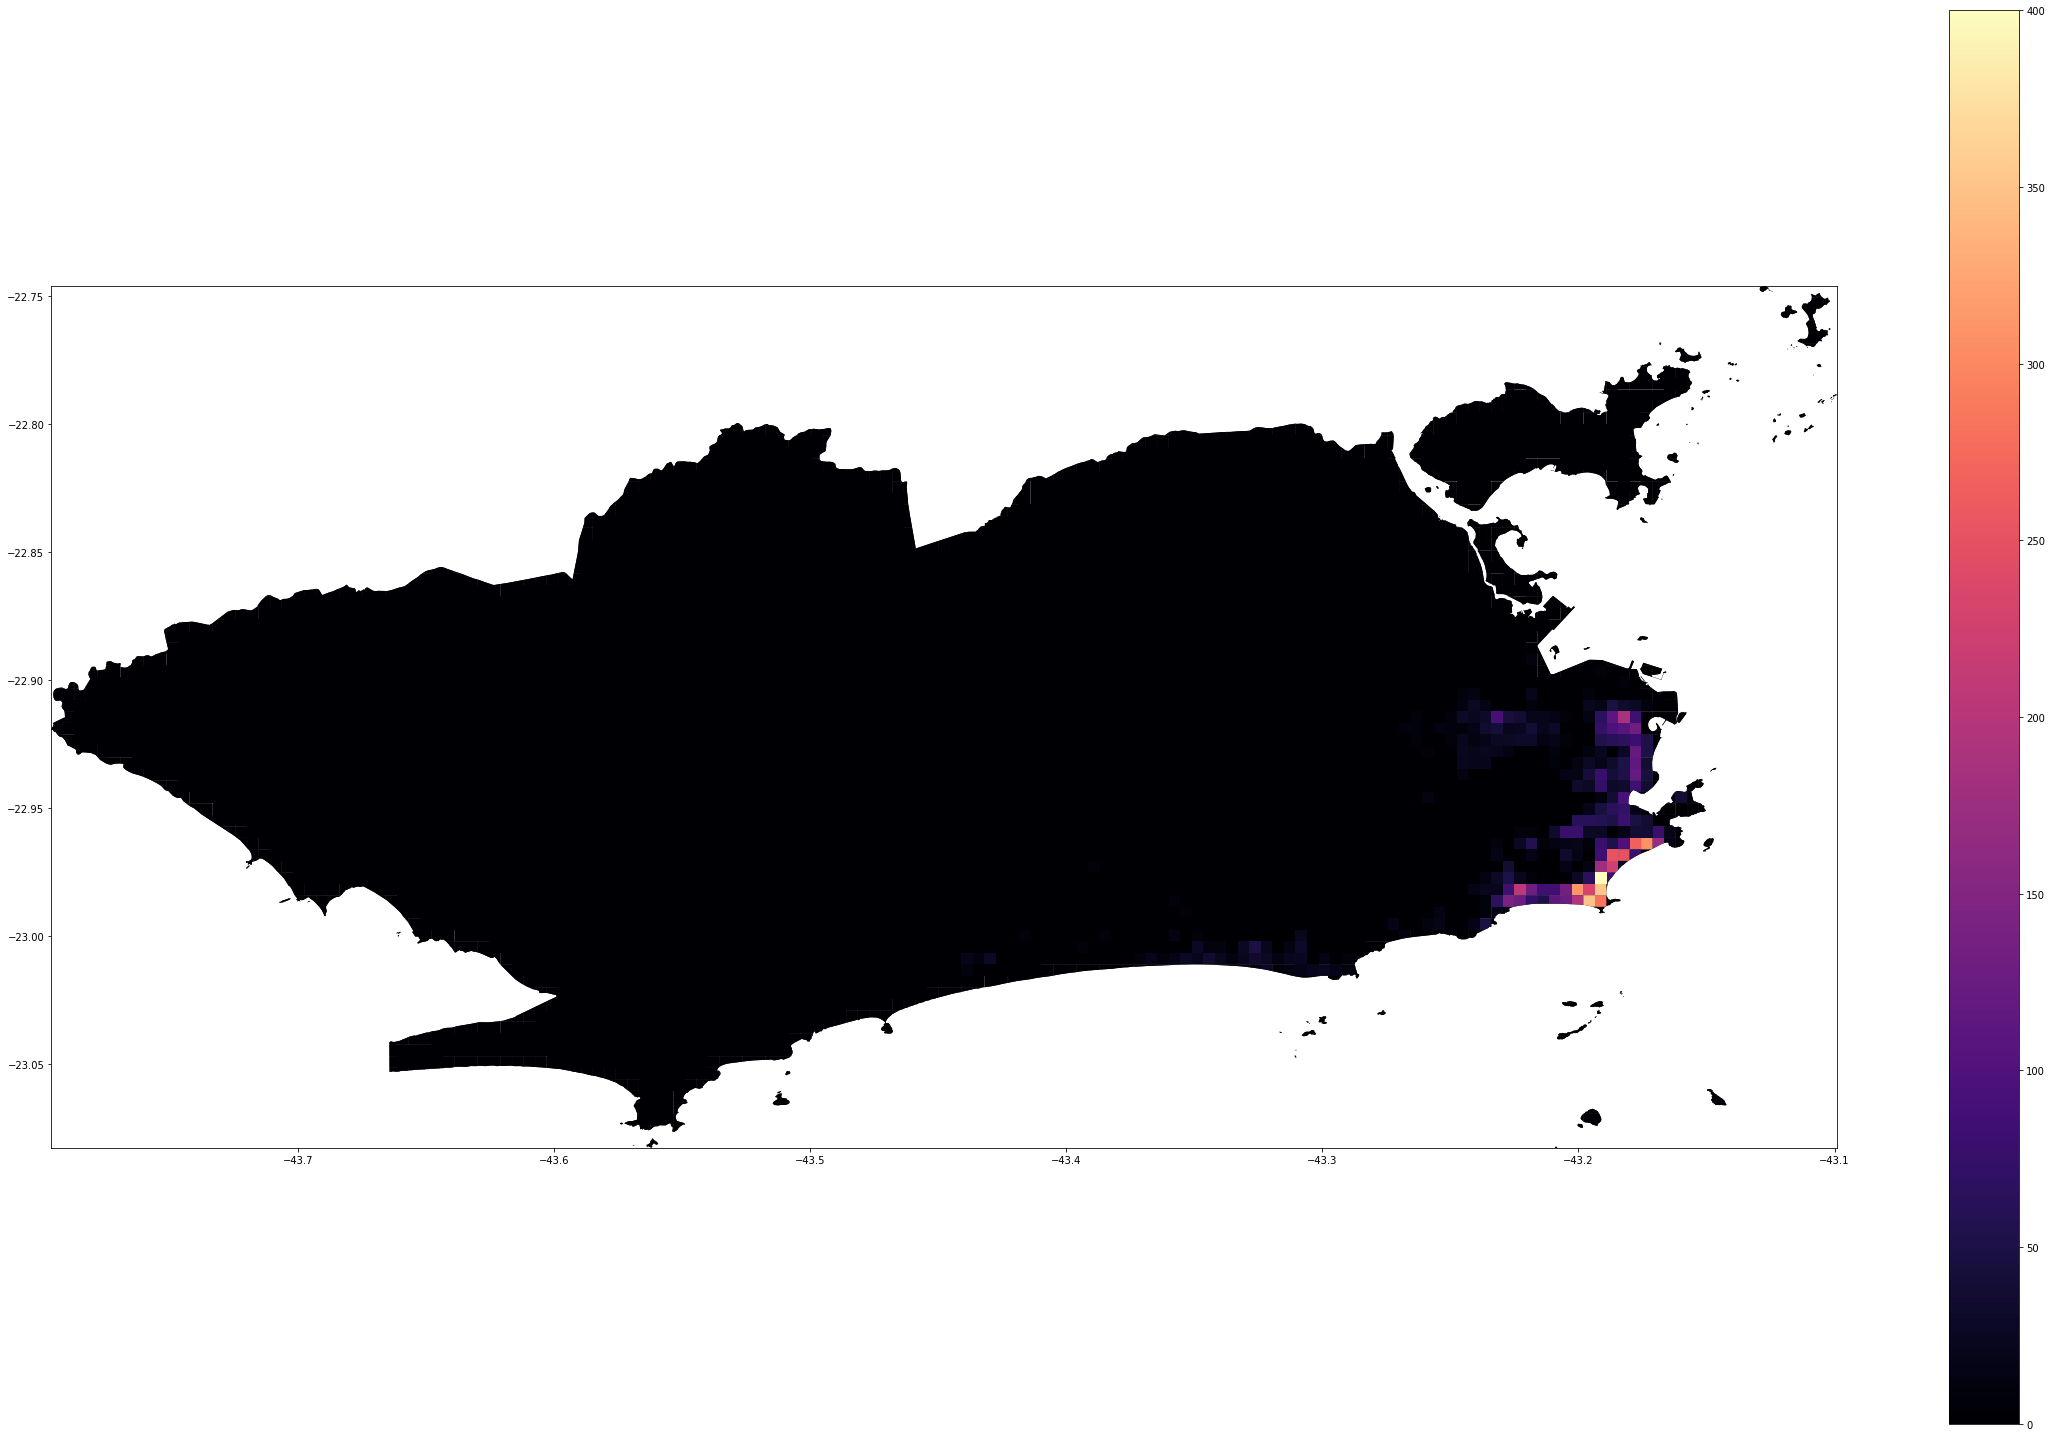

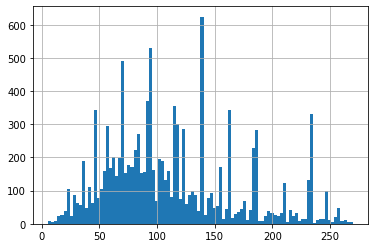

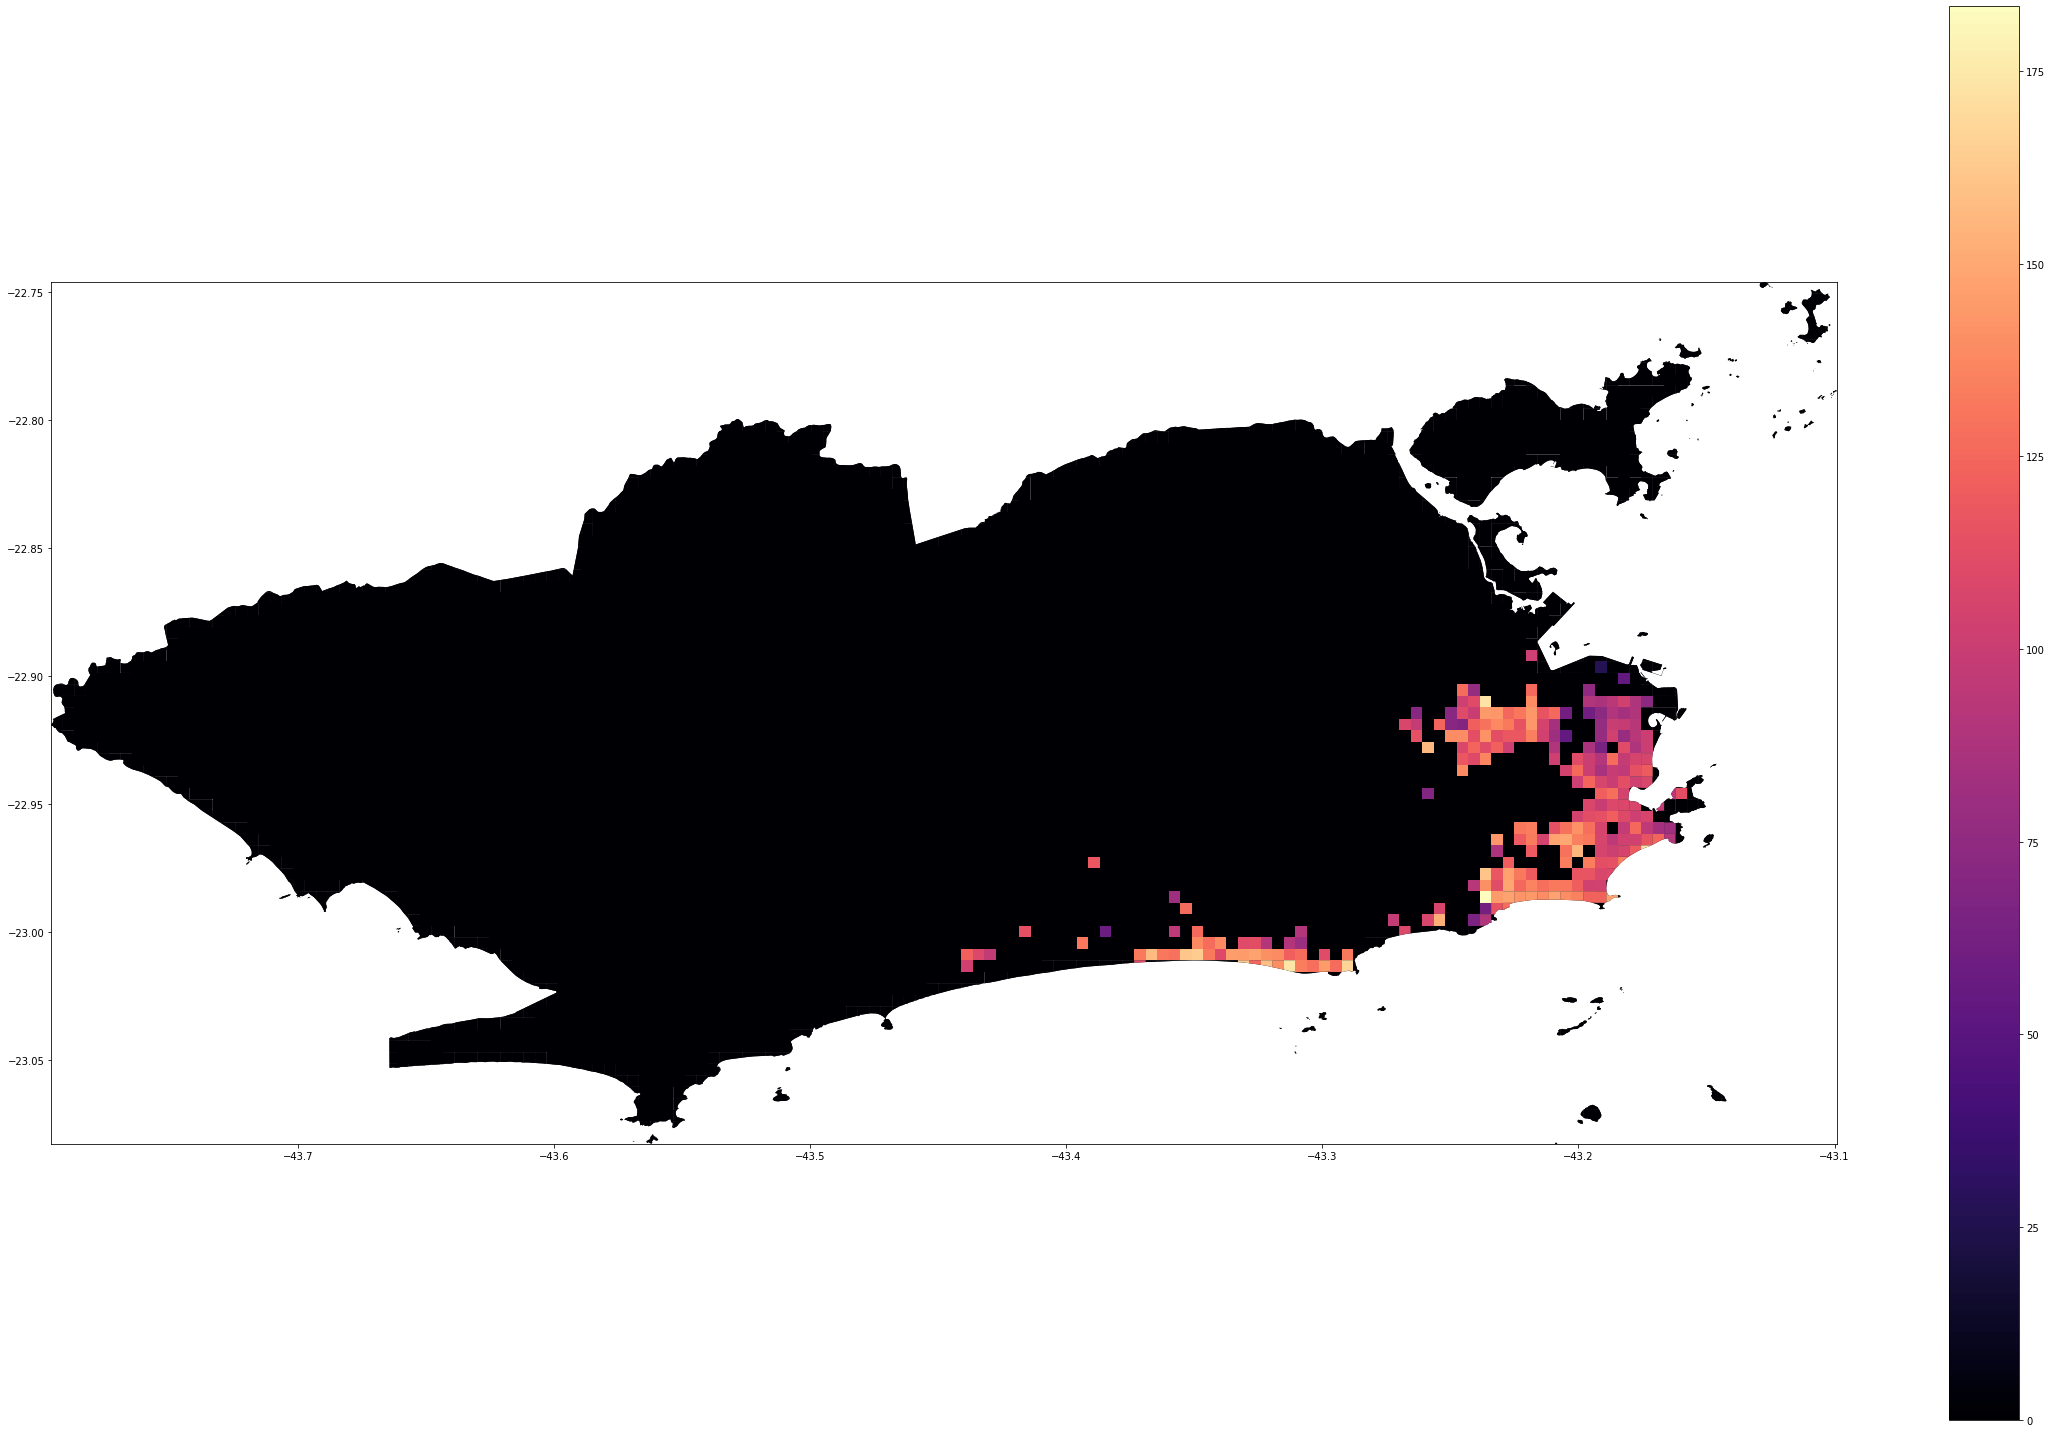

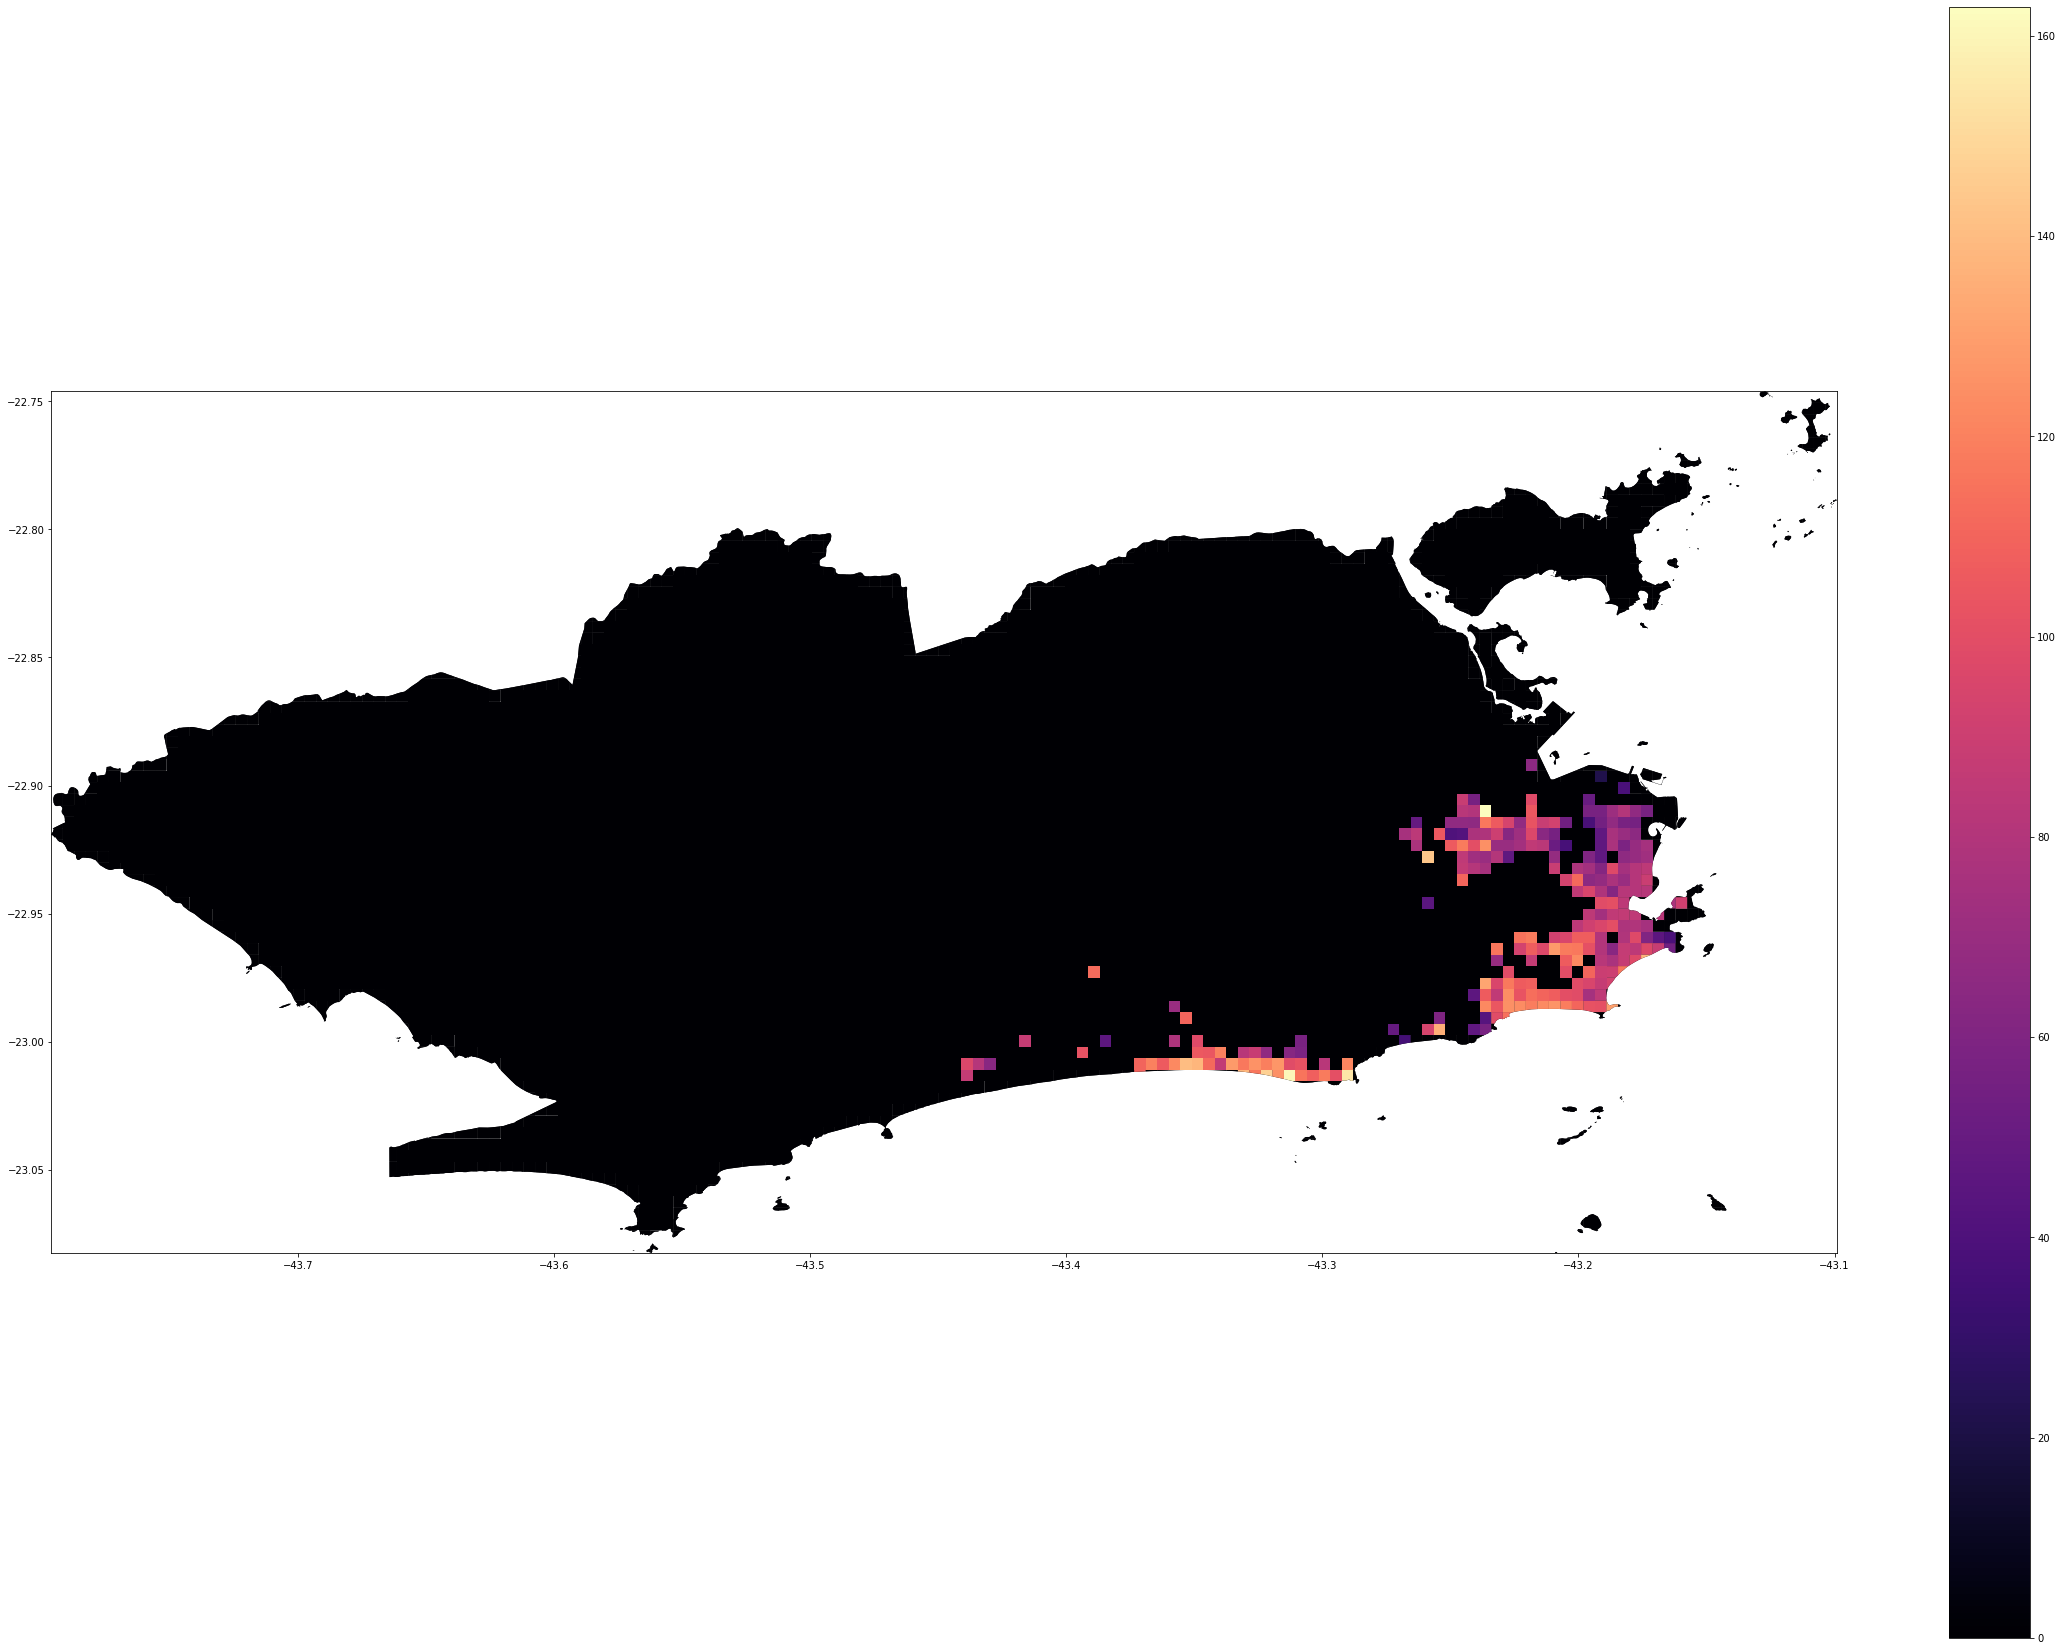

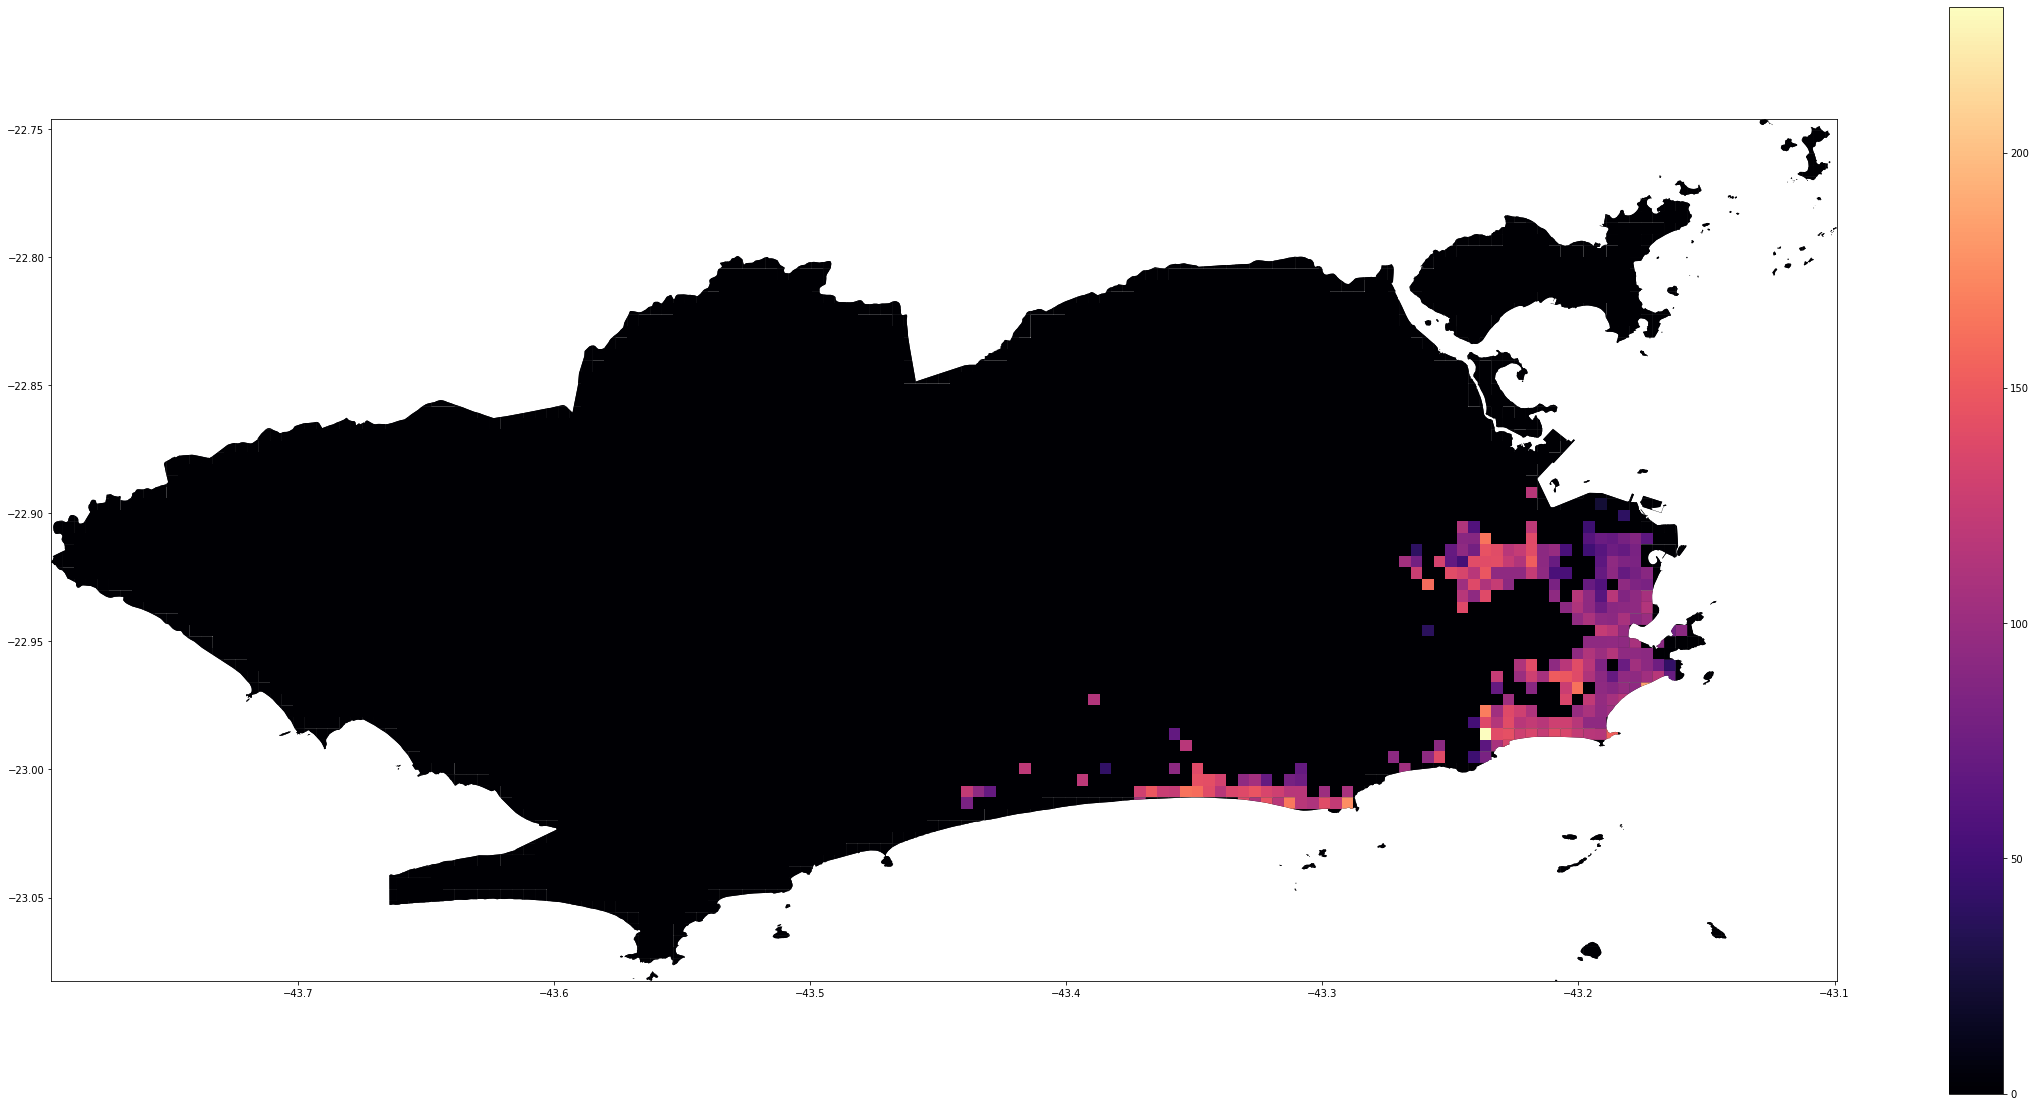

time: 28.6 s


In [3]:
data = pd.read_csv('data/Airbnb_Rio.csv', header=0, index_col=0)
data = data[['room_id','latitude', 'longitude', 'bedrooms', 'price']]
print(len(data))

data.reset_index(drop=True, inplace=True)
print("data max index:", data.index.max())
print("number of NA prices:", data.price.isna().sum())

data.loc[data.bedrooms == 0, 'bedrooms'] = 1

price_proom = np.divide(np.array(data[pd.notnull(data['bedrooms'])].price),np.array(data[pd.notnull(data['bedrooms'])].bedrooms))
mean_bed = np.mean(price_proom)
print("average bedroom price",mean_bed)

nan_list = data[data.bedrooms.isna()].index.tolist()
data.loc[data.bedrooms.isna(), 'bedrooms'] = np.ceil(data.loc[data.bedrooms.isna(), 'price']/mean_bed)

geometry = [Point(xy) for xy in zip(data.longitude, data.latitude)]
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(data, crs=crs, geometry=geometry)

meter_500 = 0.00899928/2


# make the geometry a multipolygon if it's not already
geometry = city['geometry'].iloc[0]
if isinstance(geometry, Polygon):
    geometry = MultiPolygon([geometry])
    
# quadrat_width is in the units the geometry is in, so we'll do a tenth of a degree
geometry_cut = ox.quadrat_cut_geometry(geometry, quadrat_width=meter_500)

city['coords'] = city['geometry'].apply(lambda x: x.representative_point().coords[:])
city['coords'] = [coords[0] for coords in city['coords']]

polylist = [p for p in geometry_cut]

polyframe = gpd.GeoDataFrame(geometry=polylist)
polyframe.crs = city.geometry.crs
polyframe['center_lon'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][0])
polyframe['center_lat'] = polyframe['geometry'].apply(lambda x: x.centroid.coords[0][1])


pointInPoly = gpd.sjoin(polyframe, gdf, op='contains')
print("pointinpoly length:",len(pointInPoly))

#pointInPoly.sort_values(['PlateID', 'Time'], inplace=True)
pointInPoly['index'] = pointInPoly.index
pointInPoly.reset_index(drop=True, inplace=True)


present_ind = list(pointInPoly['index_right'])
gdf_test_dropped = gdf.iloc[present_ind,:]
gdf_dropped = gdf_test_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)

print("check contains:",polyframe.iloc[pointInPoly.loc[len(pointInPoly)-1, 'index']].geometry.contains(gdf_dropped.loc[len(pointInPoly)-1,'geometry']))
gdf_dropped['pindex'] = pointInPoly['index']

print("check if there are NAs:", gdf_dropped.isna().values.any())

pindex = gdf_dropped.pindex.unique()
airbnb_dict = dict(gdf_dropped.pindex.value_counts())
counts = pd.DataFrame(list(airbnb_dict.items()), columns=['key', 'count'])
counts = counts[counts['count']>7]
counts = counts.copy()
airbnb_dict = dict(zip(list(counts['key']), list(counts['count'])))
polyair = polyframe.copy()
polyair['count'] = 0
polyair['count'].update(pd.Series(airbnb_dict))

# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='count',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


gdf_dropped = gdf_dropped[gdf_dropped.pindex.isin(airbnb_dict.keys())]
gdf_dropped = gdf_dropped.copy()
gdf_dropped = gdf_dropped[gdf_dropped['price'] > 0]
gdf_dropped = gdf_dropped.copy()
gdf_dropped['price_normalized'] = gdf_dropped.price.divide(gdf_dropped.bedrooms)
gdf_dropped = gdf_dropped[gdf_dropped.price_normalized<270]
gdf_dropped = gdf_dropped.copy()
gdf_dropped.reset_index(drop=True, inplace=True)
gdf_dropped.price_normalized.hist(bins=100)

prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].mean())
from scipy import stats
hmean_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].apply(lambda x: stats.hmean(x)))
median_prices_dict = dict(gdf_dropped.groupby('pindex')['price_normalized'].median())

polyair['prices'] = 0
polyair['hmean_prices'] = 0
polyair['median_prices'] = 0
polyair['prices'].update(pd.Series(prices_dict))
polyair['hmean_prices'].update(pd.Series(hmean_prices_dict))
polyair['median_prices'].update(pd.Series(median_prices_dict))


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()



# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,30))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='hmean_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))
polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='median_prices',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()


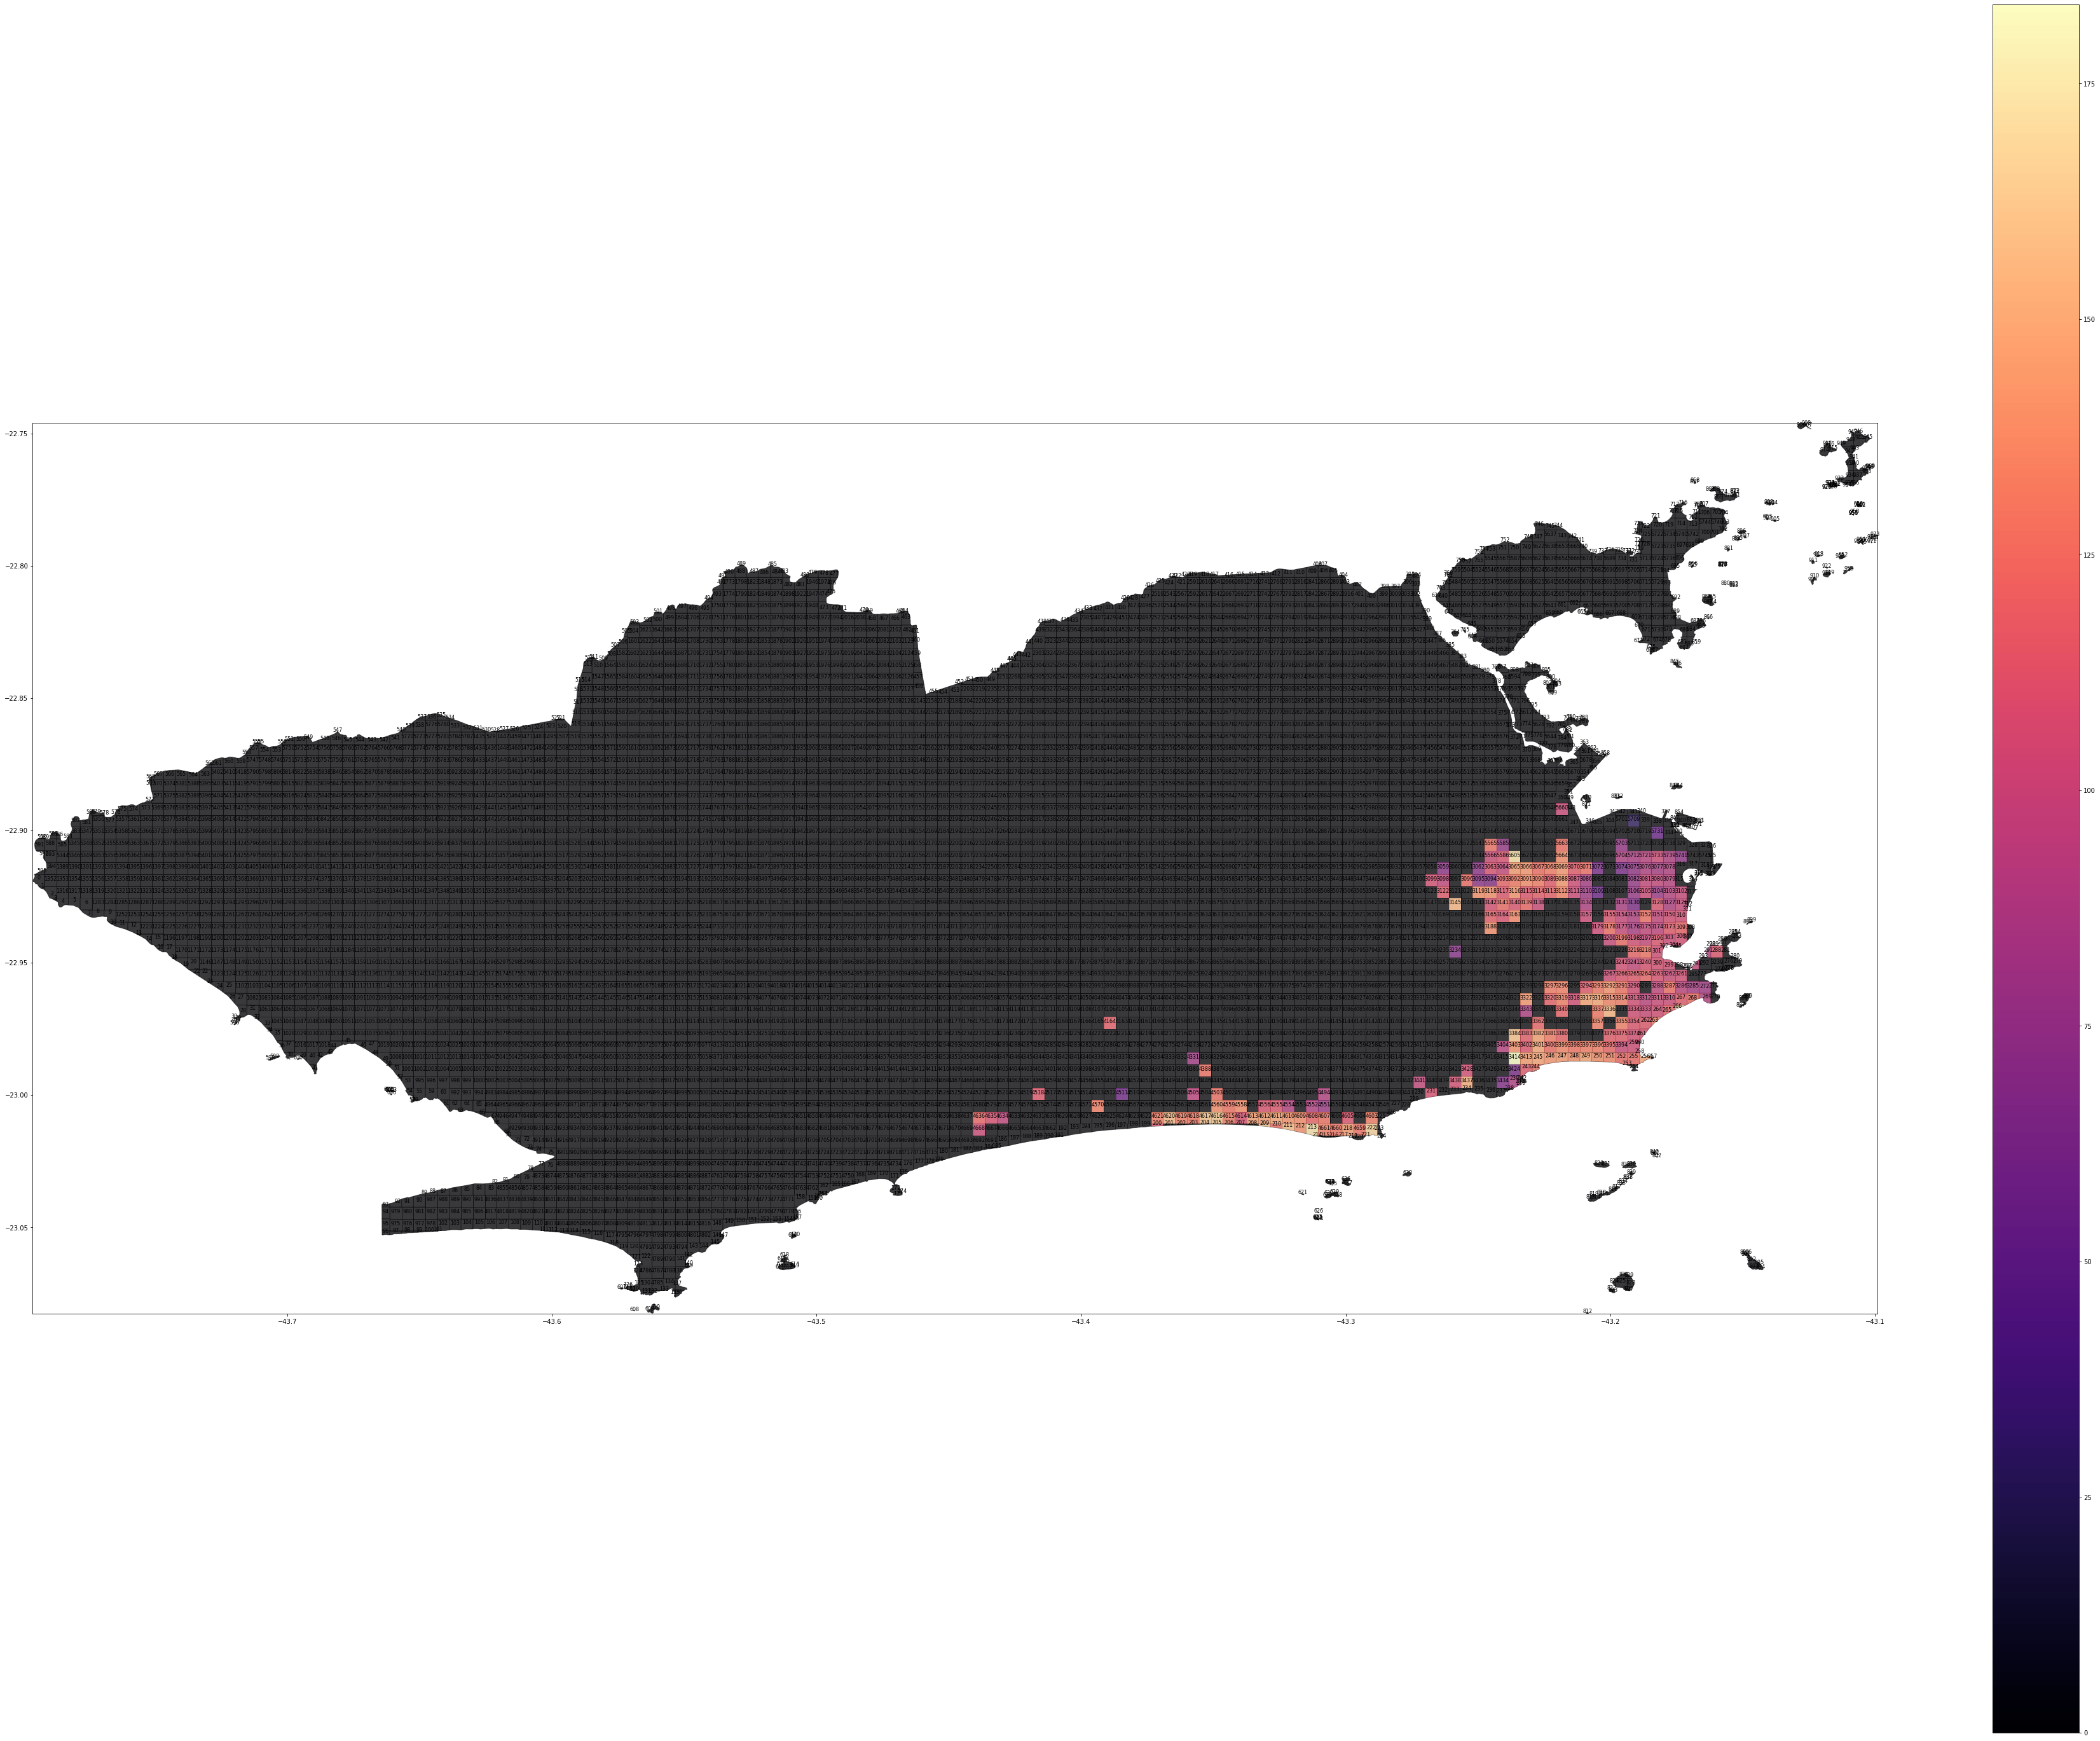

time: 57.4 s


In [5]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(65,50))
for polygon, n in zip(geometry_cut, np.arange(len(polylist))):
    p = polygon.representative_point().coords[:][0]
    patch = PolygonPatch(polygon, fc='#ffffff', ec='#000000', alpha=0.5)
    ax.add_patch(patch)
    plt.annotate(s=n, xy=p,
                 horizontalalignment='center', size=8)
polyframe.plot(ax=ax, color='#000004', alpha=0.5)
polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax, alpha=0.7, zorder=2)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

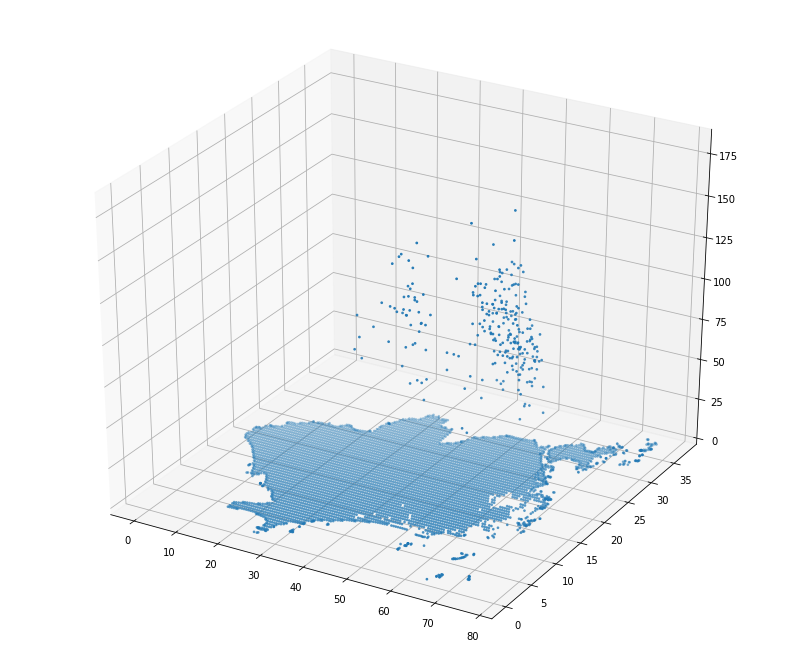

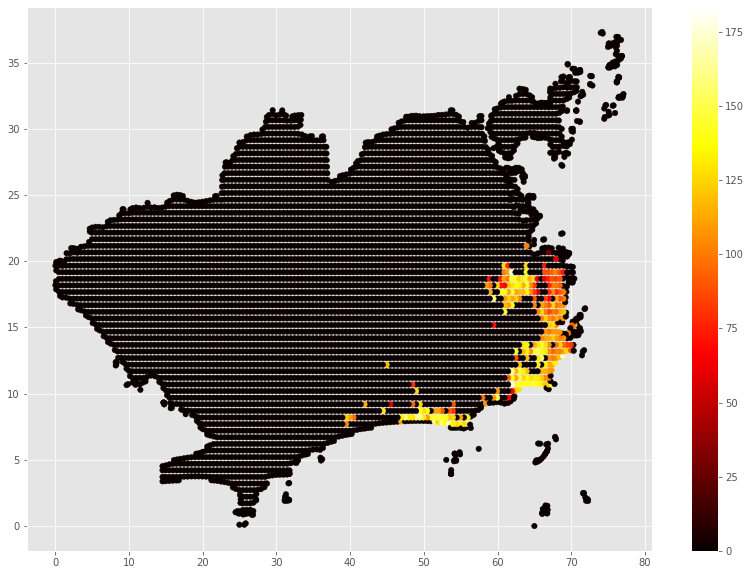

time: 2.4 s


In [6]:
import plotly.plotly as py
import plotly.graph_objs as go

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab
from mpl_toolkits.mplot3d import Axes3D
#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)

x = np.array(polyair.center_lon)*500/meter_500
x = x-x.min()
x = x/1000

y = np.array(polyair.center_lat)*500/meter_500 
y = y-y.min()
y = y/1000


# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, np.array(polyair.prices), cmap='plasma', s=3)
ax.set_zlim(0,np.max(np.array(polyair.prices))+2)
ax.view_init(30, 300)
plt.show()


plt.style.use('ggplot')
fig, ax = plt.subplots(figsize=(14,10))
scat = ax.scatter(x, y, c=np.array(polyair.prices), s=30, cmap='hot')
cbar = fig.colorbar(scat)
#cbar.set_clim(0, 250)
plt.savefig('images/Rio_observed.jpg')
plt.show()

In [7]:
cdf = polyair[polyair.index.isin([4636,4617,213, 3437, 3414, 5605, 3336, 3152, 3145])]
cdf["cen_lon_km"] = cdf['center_lon'].apply(lambda x: (x*500/meter_500 - (polyair.center_lon*500/meter_500).min())/1000)
cdf["cen_lat_km"] = cdf['center_lat'].apply(lambda x: (x*500/meter_500 - (polyair.center_lat*500/meter_500).min())/1000)
cdf

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



geometry  center_lon  \
213   POLYGON ((-43.31164686300833 -23.0153816399955...  -43.312647   
3145  POLYGON ((-43.25650678710127 -22.9256170266711...  -43.258756   
3152  POLYGON ((-43.18454075871418 -22.9301052573378...  -43.186790   
3336  POLYGON ((-43.19803438903676 -22.9660111026711...  -43.200283   
3414  POLYGON ((-43.2340174032303 -22.98396402533783...  -43.236266   
3437  POLYGON ((-43.25200891032708 -22.9929404866711...  -43.254258   
4617  POLYGON ((-43.35096219935934 -23.0064051786711...  -43.353211   
4636  POLYGON ((-43.43642185806902 -23.0064051786711...  -43.438671   
5605  POLYGON ((-43.2385152799955 -22.9076641040045,...  -43.236266   

      center_lat  count      prices  hmean_prices  median_prices  cen_lon_km  \
213   -23.012997     14  173.486111    160.552437     165.500000   53.445200   
3145  -22.927861      8  155.895833    143.522837     159.166667   59.433560   
3152  -22.932349     32  127.209677     97.754444     117.000000   67.430425   
3336  -22.968255     15  154.953333    123.359578     162.500000   65.931012   
3414  -22.986208      9  183.392857    122.496751     231.000000   61.932580   
3437  -22.995185     16  152.578788    135.156069     139.000000   59.933364   
4617  -23.008649     28  161.890000    140.541344     163.000000   48.937674   
4636  -23.008649     20  122.075000     96.367824     122.666667   39.441397   
5605  -22.909908     15  172.904762    162.902571     163.500000   61.932580   

      cen_lat_km  
213     7.714091  
3145   17.174346  
3152   16.675614  
3336   12.685756  
3414   10.690827  
3437    9.693363  
4617    8.197166  
4636    8.197166  
5605   19.169275

time: 453 ms


In [38]:
alphas = {}
xy = np.vstack([x, y])
zobs = np.array(polyair.hmean_prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//7):
        arr += twoD_Gaussian_alpha(xy, *args[i*7:i*7+7])
    return arr




guess_prms = [(173.486,53.445200,7.714091, 1.8, 2.1,0.58, 1.1),
              #(155.895,59.433560,17.174346, 1.2, 2.7,1.4, 1.5),
              (127.2,67.430425, 16.675614, 1.5, 2.5,0.87, 1.5),
              (154.95,65.931012,12.685756, 3, 2,2.87, 1.5),
              (183.39,61.932580, 10.690827, 3, 2.5,1.87, 1.5),
              #(152.58,59.933364, 9.693363, 2.5, 3,1.87, 1.5),
              (161.89,48.937674, 8.197166, 2.5, 1.5,3.87, 1.5),
              (122,39.441397, 8.197166, 2.5, 2,1.87, 1.5),
              (172.9,61.932580,19.169275, 3.5, 4,0.87, 1.5)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian_alpha(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, alpha):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2))**alpha)
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//7):
    zpred += twoD_Gaussian_alpha(xy, *popt[i*7:i*7+7])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=25, cmap='hot')
fig.colorbar(scat)
plt.savefig('Rio_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=10, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=5, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.median_prices))+2)
ax.view_init(35, 150)
plt.show()

alphas['Rio'] = np.mean(popt[6::7])
print(alphas)

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.

time: 54 s


In [39]:
import pickle
pickle_in = open("alphas.pickle","rb")
alphas_dict = pickle.load(pickle_in)
#prices_params_dict = {}
alphas_dict['Rio'] = 1.26258945858
print(alphas_dict)
pickle_out = open("alphas.pickle","wb")
pickle.dump(alphas_dict, pickle_out)
pickle_out.close()

{'Paris': 1.9119263949210794, 'Amsterdam': 1.6077156181165682, 'Stockholm': 1.4869621148124246, 'Arezzo': 1.5291330654483044, 'Berlin': 1.3281036059479567, 'Bordeaux': 1.387341915093677, 'Denver': 0.9886695315944182, 'Edinburgh': 1.7431661910906637, 'Lyon': 1.840995035260712, 'Madrid': 1.561423826026336, 'Buenos_Aires': 2.0626361633770363, 'Los_Angeles': 1.7386638625850566, 'Beijing': 1.77233254047711, 'Florence': 1.052999973906332, 'Moscow': 1.822610958759147, 'Porto': 1.4172416677632145, 'Prague': 1.3671832768992007, 'Reykjavik': 1.4194582940670377, 'Riga': 1.4587192546215861, 'Rome': 1.8608390724186512, 'Seoul': 1.3208669147673713, 'Siena': 0.6212787996336754, 'Sydney': 2.584174464016137, 'Tallin': 2.014994948135572, 'Treviso': 1.07320426583068, 'Valencia': 1.5432619, 'Venezia': 1.3156028460923, 'Verona': 1.4364606330705336, 'Vicenza': 1.20971848439062, 'Vienna': 1.3399164167136137, 'Wellington': 1.46363348, 'Zurich': 1.72383878, 'Aarhus': 1.87621535, 'Milan': 2.1468310347956194, 'B

Fitted parameters:
[ 5.66140724e+02  5.37329593e+01  7.94561267e+00  1.48999595e+00
  1.38303965e-01  3.18618395e+00  1.39062989e+02  6.26838839e+01
  1.81055393e+01  7.99591506e-01 -1.97297527e+00  1.43671633e+00
  1.17323971e+02  6.75657496e+01  1.62039357e+01  1.16484595e+00
  2.07237285e+00 -3.03765748e+00  1.14149937e+02  6.68497578e+01
  1.30352408e+01 -6.90860314e-01  2.91843270e+00  1.64981810e+00
  1.67735759e+02  6.40422654e+01  1.08686652e+01  6.72988135e-01
  2.11172735e+00 -7.85095874e+00  2.00801240e+02  5.80676044e+01
  7.63623267e+00 -9.24605944e-03  4.50316310e+00  1.82444294e+00
  2.77187431e+02  4.96895229e+01  8.41352359e+00  1.77116043e-01
  1.80721277e+00  4.65214726e+00  2.29971350e+02  3.97042589e+01
  8.00829393e+00  1.79342662e-01  4.97507767e-01  4.56537549e+00
  5.98405725e+01  6.12974584e+01  1.80880586e+01  1.59693031e+00
 -5.26675285e-01  1.57437965e+00]
RMS residual = 12.90672843268453


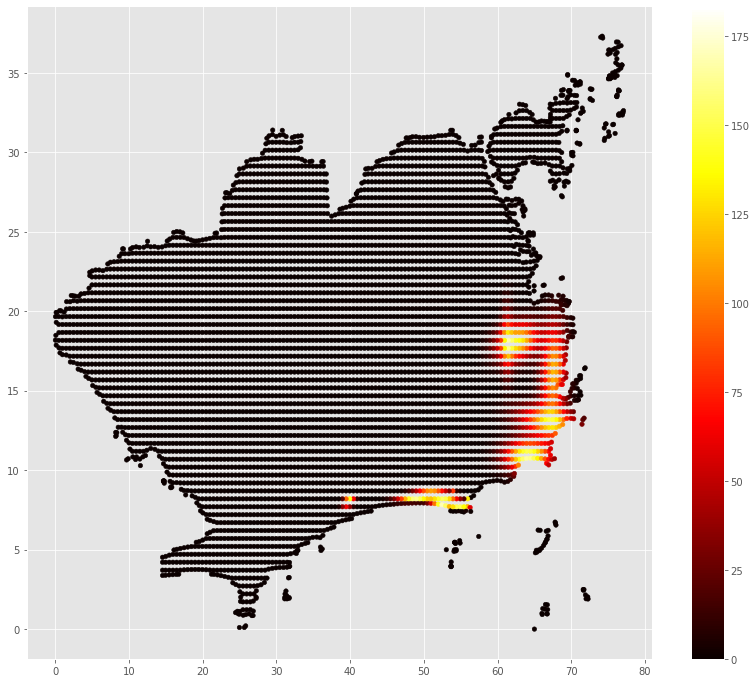

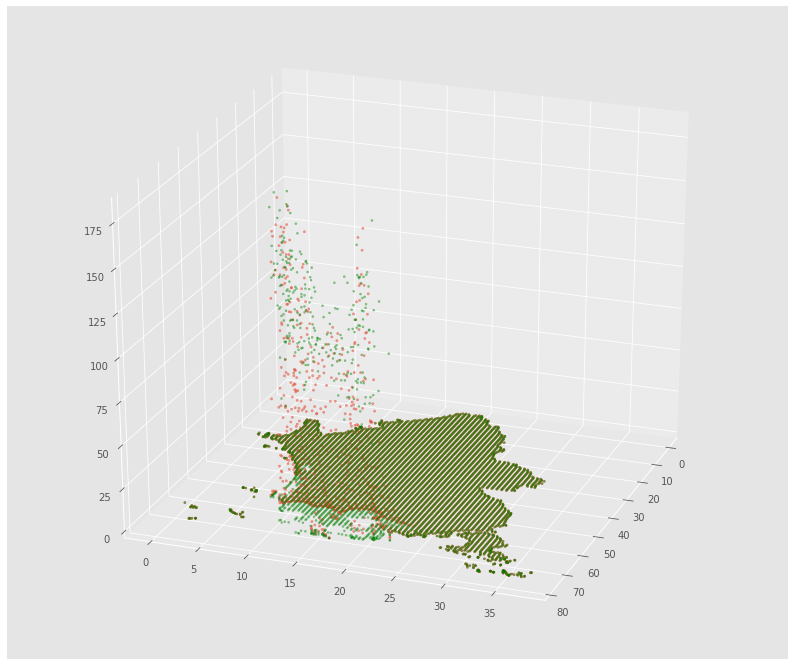

time: 15.1 s


In [40]:
xy = np.vstack([x, y])
zobs = np.array(polyair.prices)
#zobs = np.where(zobs>0, zobs, 0.1*zobs.max())
import scipy.optimize as opt
import matplotlib.pyplot as plt

def _gaussian(M, *args):
    xy = M
    arr = np.zeros(len(zobs))
    for i in range(len(args)//6):
        arr += twoD_Gaussian(xy, *args[i*6:i*6+6])
    return arr


guess_prms = [(173.486,53.445200,7.714091, 1.8, 2.1,0.58),
              (155.895,59.433560,17.174346, 1.2, 2.7,1.4),
              (127.2,67.430425, 16.675614, 1.5, 2.5,0.87),
              (154.95,65.931012,12.685756, 3, 2,2.87),
              (183.39,61.932580, 10.690827, 3, 2.5,1.87),
              (152.58,59.933364, 9.693363, 2.5, 3,1.87),
              (161.89,48.937674, 8.197166, 2.5, 1.5,3.87),
              (122,39.441397, 8.197166, 2.5, 2,1.87),
              (172.9,61.932580,19.169275, 3.5, 4,0.87)
             ]

# Flatten the initial guess parameter list.
p0 = [p for prms in guess_prms for p in prms]

def twoD_Gaussian(xy, amplitude, xo, yo, sigma_x, sigma_y, theta):
    x, y = xy
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()
popt, pcov = opt.curve_fit(_gaussian, xy, zobs, p0)
#pred_params, uncert_cov = opt.curve_fit(gauss2d, xy, zobs, p0=guess)

zpred = np.zeros(len(zobs))
for i in range(len(popt)//6):
    zpred += twoD_Gaussian(xy, *popt[i*6:i*6+6])

# for i in range(len(popt)//5):
#     fit += gaussian(X, Y, *popt[i*5:i*5+5])
print('Fitted parameters:')
print(popt)

rms = np.sqrt(np.mean((zobs - zpred)**2))
print('RMS residual =', rms)


fig, ax = plt.subplots(figsize=(14,12))
scat = ax.scatter(x, y, c=zpred, vmin=0, vmax=zobs.max(), s=20, cmap='hot')
fig.colorbar(scat)
plt.savefig('Rio_fitted.jpg')
plt.show()


#x, y = np.array(polyair.center_lon), np.array(polyair.center_lat)
# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure(figsize=(14,12))
ax = fig.gca(projection='3d')
ax.scatter(x, y, zpred, cmap='plasma', s=5, alpha=0.5)
ax.scatter(x, y, zobs, color='green', s=4, alpha=0.4)
ax.set_zlim(0,np.max(np.array(polyair.prices))+2)
ax.view_init(25, 20)
plt.show()

In [41]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

sqrt_eigs_long = np.array([])
sqrt_eigs_short = np.array([])
for i in range(0, len(popt), 6):
    a = (np.cos(popt[i+5])**2)/(2*popt[i+3]**2) + (np.sin(popt[i+5])**2)/(2*popt[i+4]**2)
    b = -(np.sin(2*popt[i+5]))/(4*popt[i+3]**2) + (np.sin(2*popt[i+5]))/(4*popt[i+4]**2)
    c = (np.sin(popt[i+5])**2)/(2*popt[i+3]**2) + (np.cos(popt[i+5])**2)/(2*popt[i+4]**2)
    cov = np.array([a, b, b, c]).reshape(-1, 2)
    print("Is cov_{} positive definite?: ".format(i//6+1), is_pos_def(cov))
    eigenvalues = np.linalg.eigvals(cov)
    eigenvalues = eigenvalues[eigenvalues>0]
    if eigenvalues.size!=0:
        stds = np.sqrt(eigenvalues)/popt[i]
        #stds = stds[stds>=0]
        sqrt_eigs_long = np.append(sqrt_eigs_long,max(stds))
        sqrt_eigs_short = np.append(sqrt_eigs_short,min(stds))

print('long stds: ', sqrt_eigs_long, 'mean: ', np.mean(sqrt_eigs_long))
print('short stds: ', sqrt_eigs_short, 'mean: ', np.mean(sqrt_eigs_short))

Is cov_1 positive definite?:  True
Is cov_2 positive definite?:  True
Is cov_3 positive definite?:  True
Is cov_4 positive definite?:  True
Is cov_5 positive definite?:  True
Is cov_6 positive definite?:  True
Is cov_7 positive definite?:  True
Is cov_8 positive definite?:  True
Is cov_9 positive definite?:  True
long stds:  [0.00903079 0.00635924 0.00517404 0.00896642 0.006264   0.38085699
 0.01440302 0.01714461 0.02243605] mean:  0.05229279629243492
short stds:  [0.00083825 0.00257722 0.00290824 0.00212256 0.00199628 0.00078199
 0.00141157 0.00618033 0.00739952] mean:  0.0029128839657842423
time: 9.99 ms


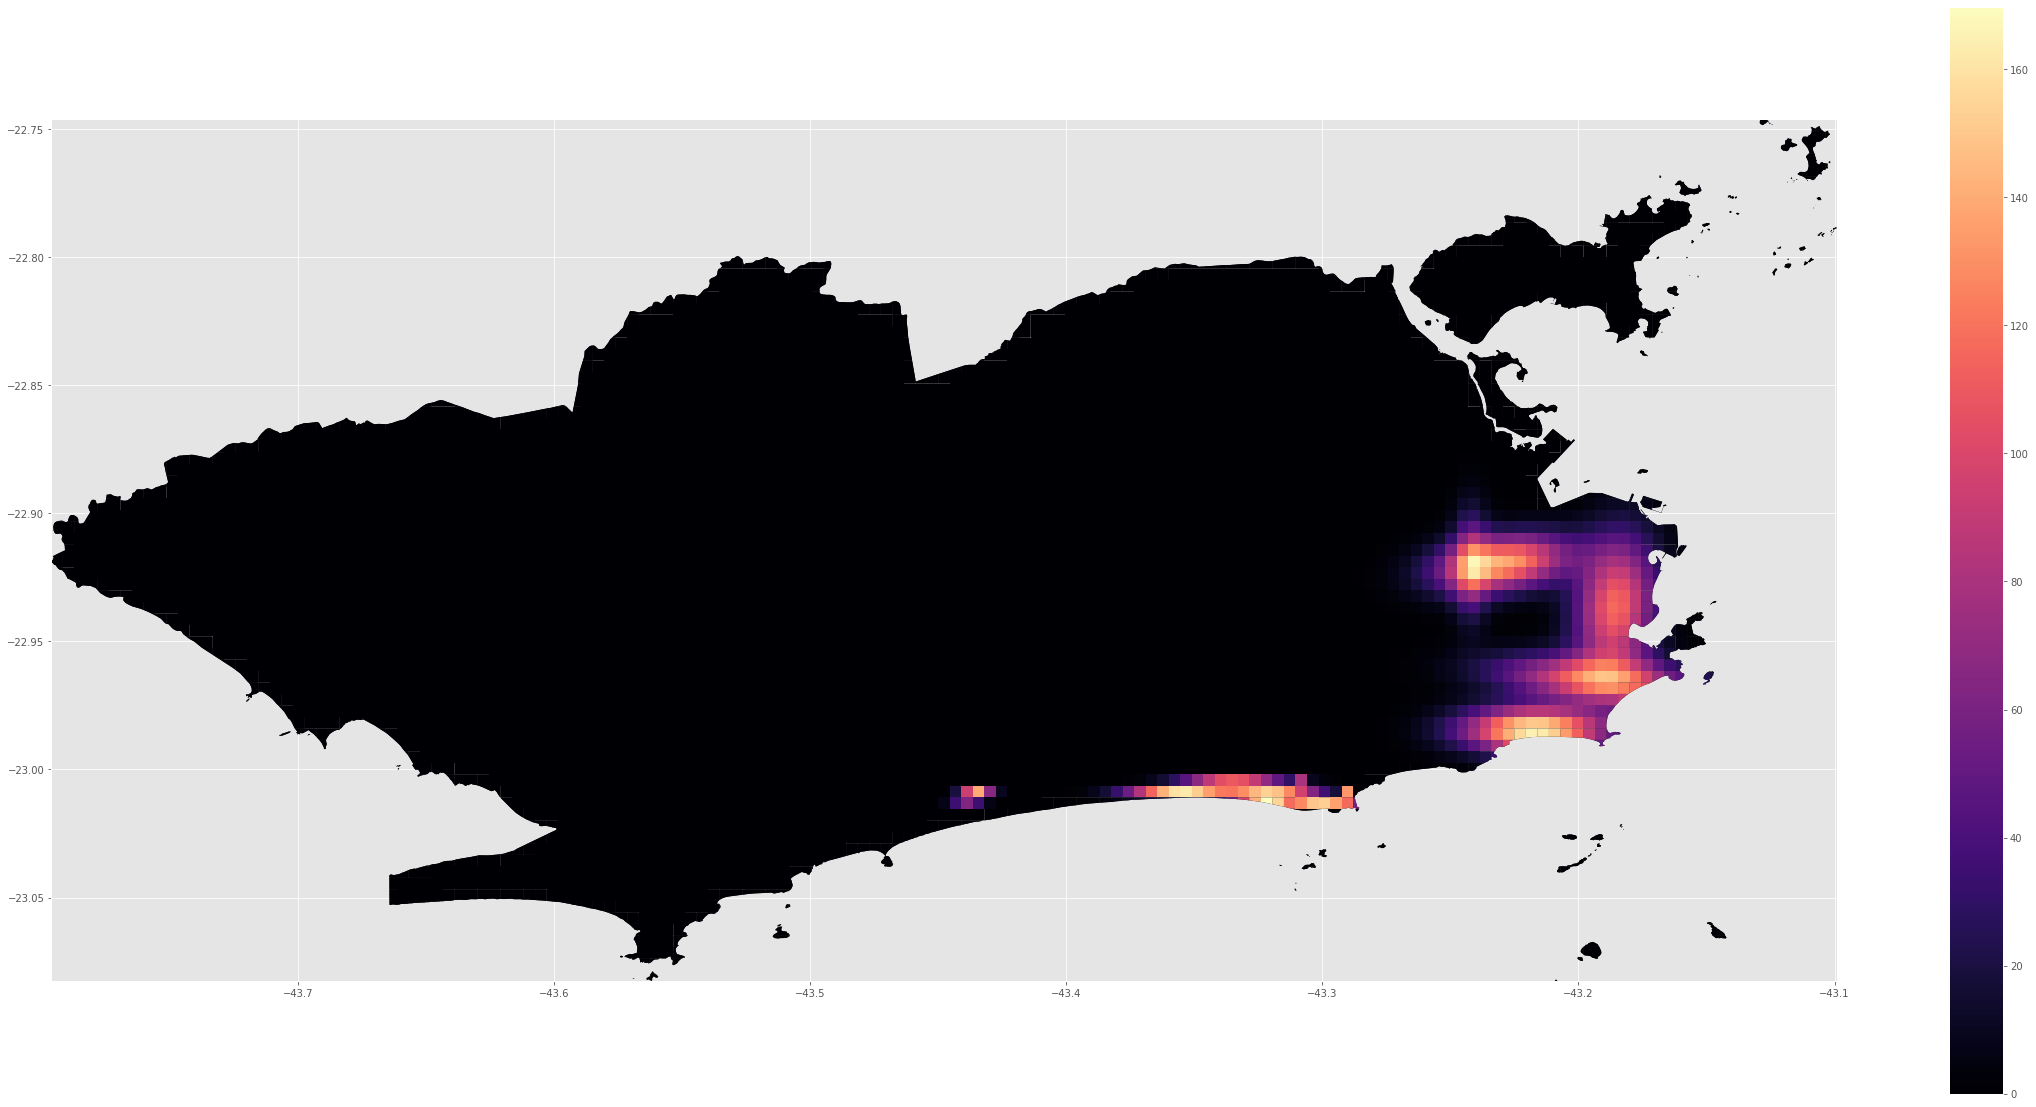

time: 3.38 s


In [42]:
polyair['zpred'] = zpred
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,20))

polyframe.plot(ax=ax, color='#000004')
polyair.plot(column='zpred',  legend=True, cmap='magma', ax=ax)    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [43]:
import pickle
pickle_in = open("Prices_params.pickle","rb")
prices_params_dict = pickle.load(pickle_in)
#prices_params_dict = {}
prices_params_dict['Rio'] = popt
pickle_out = open("Prices_params.pickle","wb")
pickle.dump(prices_params_dict, pickle_out)
pickle_out.close()

#average_slopes = {}
pickle_in_long = open("Average_price_slopes_long.pickle","rb")
average_slopes_long = pickle.load(pickle_in_long)
average_slopes_long['Rio'] = np.mean(sqrt_eigs_long)
pickle_out_long = open("Average_price_slopes_long.pickle","wb")
pickle.dump(average_slopes_long, pickle_out_long)
pickle_out_long.close()

pickle_in_short = open("Average_price_slopes_short.pickle","rb")
average_slopes_short = pickle.load(pickle_in_short)
average_slopes_short['Rio'] = np.mean(sqrt_eigs_short)
pickle_out_short = open("Average_price_slopes_short.pickle","wb")
pickle.dump(average_slopes_short, pickle_out_short)
pickle_out_short.close()

print('long: ', average_slopes_long, '\n', '\n', ' short: ', average_slopes_short)

long:  {'Paris': 0.010453121182320417, 'Amsterdam': 0.017790862401138207, 'Stockholm': 0.01160078748441716, 'Arezzo': 0.012661960610292892, 'Berlin': 0.017168942092868542, 'Bordeaux': 0.0057209390468692745, 'Denver': 0.00873766709683174, 'Edinburgh': 0.012921100209712873, 'Lyon': 0.00594530194011358, 'Madrid': 0.01315080289968449, 'Buenos_Aires': 0.00938788752473718, 'Palermo': 0.02659431146972356, 'Los_Angeles': 0.0056655377791732745, 'Beijing': 0.03548021455387483, 'Florence': 0.011913882705309832, 'Moscow': 0.026524810524746, 'Porto': 0.03745056113103571, 'Prague': 0.01850581507565583, 'Reykjavik': 0.04000475004839031, 'Riga': 0.02150786435094239, 'Rome': 0.009635062558537275, 'Seoul': 0.013154650694260608, 'Siena': 0.013838139160990736, 'Sydney': 0.009200022664460229, 'Tallin': 0.024848430854086192, 'Treviso': 0.015264513943951563, 'Valencia': 0.01982718757582555, 'Venezia': 0.013133572970121148, 'Verona': 0.01119208328282184, 'Vicenza': 0.029546407262138693, 'Vienna': 0.0120270170

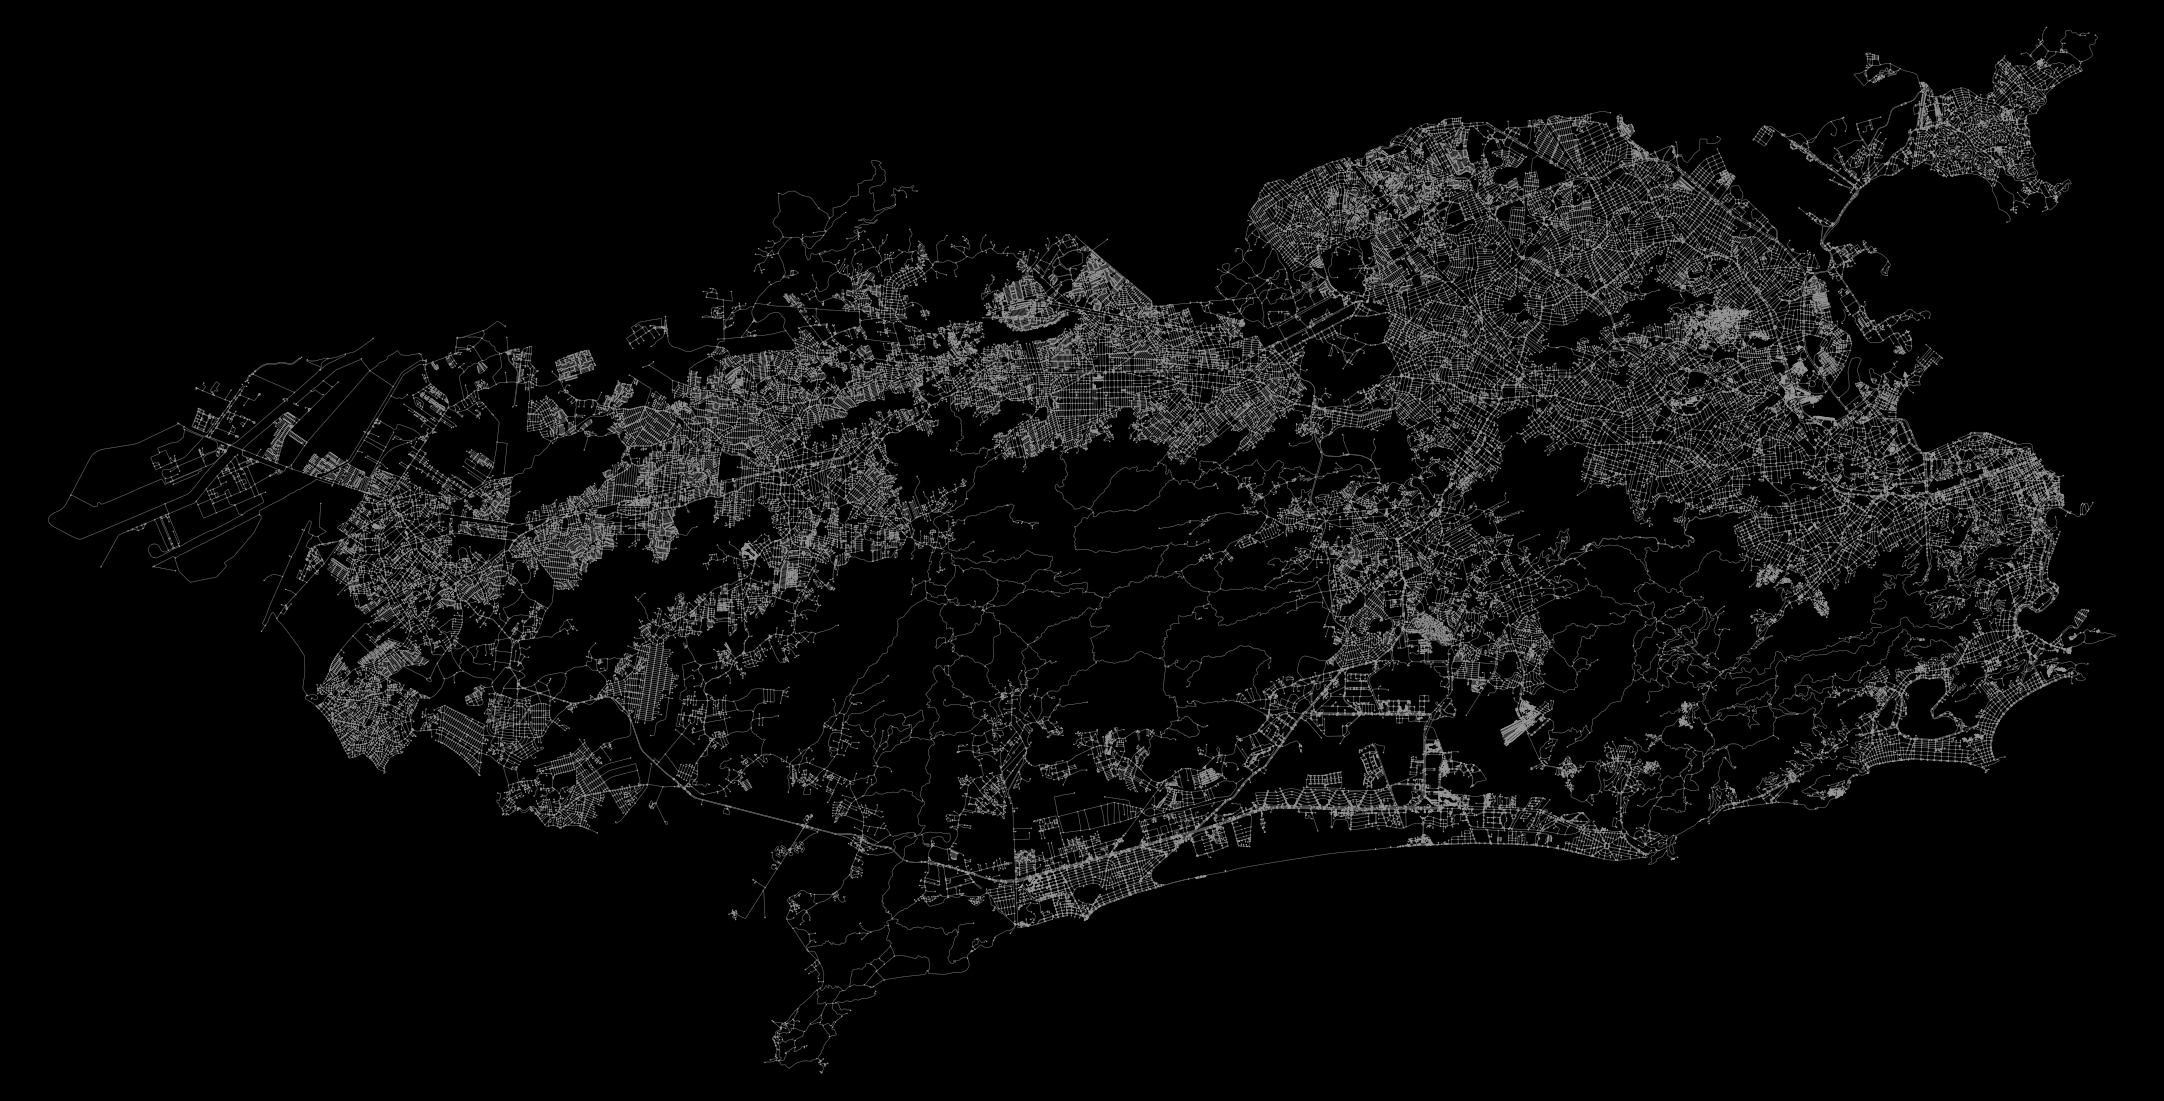

time: 2min 58s


In [44]:
# download and project a street network
G = ox.graph_from_place('Rio de Janeiro, Brazil', network_type="walk")
#G = ox.project_graph(G)
fig, ax = ox.plot_graph(G, fig_height=20, bgcolor='k', node_size=2, node_color='#999999', node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=0.5, edge_alpha=1)

In [45]:
centers = {}
for i in range(0, len(popt), 6):
    lon = popt[i+1]*1000 + (np.array(polyair.center_lon)*500/meter_500).min()
    lon = lon*meter_500/500
    lat = popt[i+2]*1000 + (np.array(polyair.center_lat)*500/meter_500).min()
    lat = lat*meter_500/500
    centers['center_node_{}'.format(i//6+1)] = ox.get_nearest_node(G, (lat,lon))

centers

{'center_node_1': 511973293,
 'center_node_2': 4164284991,
 'center_node_3': 38650993,
 'center_node_4': 1901630603,
 'center_node_5': 50930725,
 'center_node_6': 1768803324,
 'center_node_7': 511973727,
 'center_node_8': 4304859000,
 'center_node_9': 634187801}

time: 2.55 s


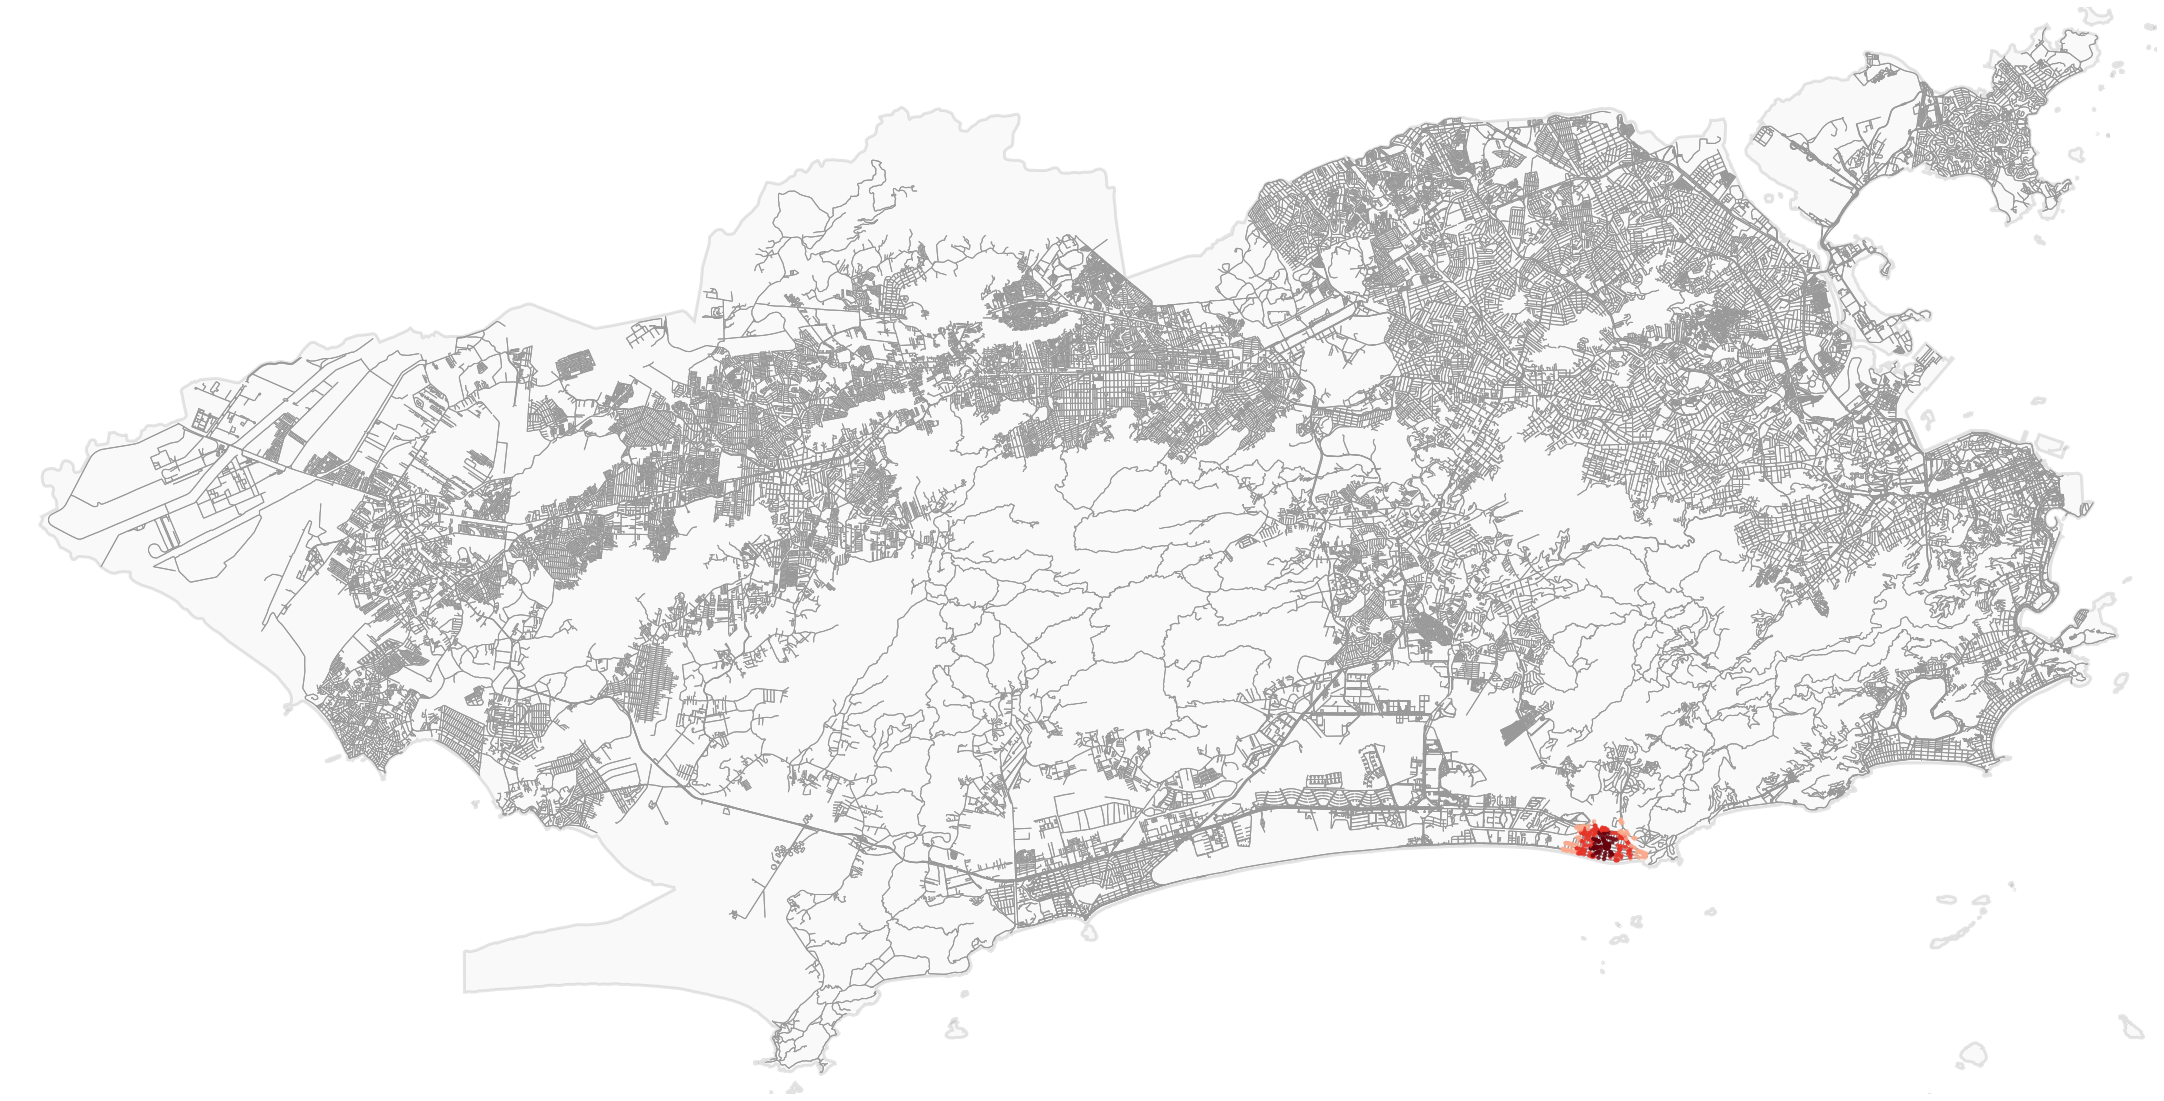

time: 42.4 s


In [46]:
import networkx as nx
#center_node = ox.get_nearest_node(G, (popt[8],popt[7]))
center_node = centers['center_node_1']
# list of distances from center
dists = np.arange(500, 2000, 500)
dists

# get one color for each isochrone
iso_colors = ox.get_colors(n=len(dists), cmap='Reds', start=0.3, return_hex=True)
# color the nodes according to isochrone then plot the street network
node_colors = {}
for dist, color in zip(sorted(dists, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=dist, distance='length')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=20,show=False, close=False, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)
plt.close()
# to this matplotlib axis, add the place shape as descartes polygon patches
for geometry in city['geometry'].tolist():
    if isinstance(geometry, (Polygon, MultiPolygon)):
        if isinstance(geometry, Polygon):
            geometry = MultiPolygon([geometry])
        for polygon in geometry:
            patch = PolygonPatch(polygon, fc='#cccccc', ec='k', linewidth=3, alpha=0.1, zorder=-1)
            ax.add_patch(patch)
            
fig

5942
5942 467
Number of cells with price above 5th percentile:  467



[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yes


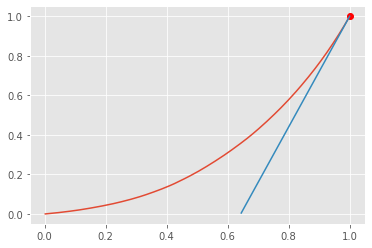

Loubar price:  70.57575912096925
Average price:  60.96947578919004
average city distance:  8357.334811118957
eta =  0.9930364580531982
time: 20.7 s


In [47]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys = np.array(keys)

vals_cut = vals[vals>0.05*vals.max()]
print(len(vals), len(vals_cut))

L = np.cumsum(vals_cut)/np.sum(vals_cut)
keys = keys[vals>0.05*vals.max()]
print('Number of cells with price above 5th percentile: ', len(keys))



mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(keys), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)
    
print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True

  
if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No") 
    
    
L1= L
F1 = np.arange(1, len(L1)+1)/len(L1)

L1 = (L1 - L1.min())/(L1.max()-L1.min())

from scipy import interpolate
tck = interpolate.splrep(F1,L1)
x0_1 =1
y0_1 = interpolate.splev(x0_1,tck)
dydx = interpolate.splev(x0_1,tck,der=1)
tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
plt.plot(F1, L1)
plt.plot(x0_1,y0_1, "or")
plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
plt.show()

indlist = poly_prices.index.tolist()

loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

print('Loubar price: ', loubar_val)
print('Average price: ', np.mean(vals_cut))

if loubar_val > np.mean(vals_cut):
    loubar_keys = keys[vals_cut>loubar_val]
else:
    loubar_keys = keys[vals_cut>np.mean(vals_cut)]
#loubar_keys = keys[vals_cut>np.mean(vals_cut)]
dist_mat = mat[keys.reshape(-1,1), keys]

total_dist = dist_mat.sum()
dist_corr = dist_mat[dist_mat>0]

loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]
loubar_dist = loubar_dist_mat.sum()

loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
eta_loubar = loubar_dist_corr.mean()/dist_corr.mean()
avg_dist_meters = (dist_corr.mean()/0.00899928)*1000
print('average city distance: ', avg_dist_meters)
print('eta = ', eta_loubar)

In [63]:
indlist = poly_prices.index.tolist()
mat = np.zeros(shape=(len(geometry_cut), len(geometry_cut)))
for pair in tqdm_notebook(combinations(sorted(indlist), 2)):
    mat[pair[0], pair[1]] = geometry_cut[pair[0]].centroid.distance(geometry_cut[pair[1]].centroid)

print(mat)


def isuppertriangular(M): 
    for i in range(1, len(M)): 
        for j in range(0, i): 
            if(M[i][j] != 0):  
                    return False
    return True


if isuppertriangular(mat): 
    print ("Yes") 
else: 
    print ("No")

[[0.         0.00301522 0.00624327 ... 0.16251503 0.16208439 0.16177717]
 [0.         0.         0.00375869 ... 0.16184582 0.16133442 0.1609466 ]
 [0.         0.         0.         ... 0.15866175 0.15809596 0.15765595]
 ...
 [0.         0.         0.         ... 0.         0.00448823 0.00897646]
 [0.         0.         0.         ... 0.         0.         0.00448823]
 [0.         0.         0.         ... 0.         0.         0.        ]]
Yes
time: 20min 41s


5942


5942 5942
Number of cells with price above 0.0th percentile:  5942
Loubar price:  3.7472617252719463e-65
Average price:  4.9282482813768995
eta =  0.8450430236479781
5942 616
Number of cells with price above 1.010204081632653th percentile:  616
Loubar price:  9.789711508650944
Average price:  47.358292864027796
eta =  0.9596244641747674
5942 567
Number of cells with price above 2.020408163265306th percentile:  567
Loubar price:  13.798568932541587
Average price:  51.24173512028783
eta =  0.9680941592988356
5942 528
Number of cells with price above 3.030612244897959th percentile:  528
Loubar price:  16.88653489443057
Average price:  54.71757908204584
eta =  0.9457090857829864
5942 497
Number of cells with price above 4.040816326530612th percentile:  497
Loubar price:  19.874780606512257
Average price:  57.75169087520501
eta =  0.9497347508818071
5942 467
Number of cells with price above 5.051020408163264th percentile:  467
Loubar price:  23.911238308701467
Average price:  60.96947578919

Loubar price:  95.08686187417504
Average price:  114.91556806936637
eta =  1.027116325708984
5942 139
Number of cells with price above 48.48979591836734th percentile:  139
Loubar price:  96.98827278500555
Average price:  116.36158727465491
eta =  1.0182432393332963
5942 134
Number of cells with price above 49.5th percentile:  134
Loubar price:  98.12982600313296
Average price:  117.59725822136234
eta =  1.0235786072848203
5942 130
Number of cells with price above 50.51020408163265th percentile:  130
Loubar price:  99.06402715503093
Average price:  118.59904133876891
eta =  1.023952828124442
5942 126
Number of cells with price above 51.52040816326531th percentile:  126
Loubar price:  101.67908323049966
Average price:  119.60941200700222
eta =  1.0194147620964016
5942 119
Number of cells with price above 52.53061224489796th percentile:  119
Loubar price:  103.68766726666905
Average price:  121.43146344713658
eta =  1.0161856882592397
5942 114
Number of cells with price above 53.540816326

Number of cells with price above 95.96938775510205th percentile:  4
Loubar price:  164.97265149795945
Average price:  166.3484691565169
eta =  1.5165212872374705
5942 3
Number of cells with price above 96.97959183673468th percentile:  3
Loubar price:  164.97265149795945
Average price:  167.42536125929755
eta =  1.2316235810053056
5942 2
Number of cells with price above 97.98979591836734th percentile:  2
Loubar price:  167.53651072620409
Average price:  168.65171613996657


C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:69: RuntimeWarning:

Mean of empty slice.



eta =  nan
5942 1
Number of cells with price above 99.0th percentile:  1


C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:37: RuntimeWarning:

invalid value encountered in true_divide



Loubar price:  169.76692155372905
Average price:  169.76692155372905
eta =  nan


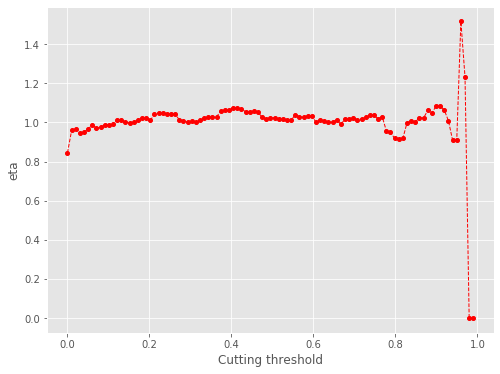

time: 3.84 s


In [71]:
from tqdm import tqdm_notebook

#poly_prices = polyair[polyair.median_prices>0]
poly_prices = polyair.copy()
print(len(poly_prices))
poly_prices['zpred'] = zpred

lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
keys_initial = np.array(keys)


perc_vals = np.linspace(0, 0.99, 99)
etas_cut = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    
    
        
    L1= L
    F1 = np.arange(1, len(L1)+1)/len(L1)

    L1 = (L1 - L1.min())/(L1.max()-L1.min())

#     from scipy import interpolate
#     tck = interpolate.splrep(F1,L1)
#     x0_1 =1
#     y0_1 = interpolate.splev(x0_1,tck)
#     dydx = interpolate.splev(x0_1,tck,der=1)
#     tngnt1 = lambda x: dydx*x + (y0_1-dydx*x0_1)
#     plt.plot(F1, L1)
#     plt.plot(x0_1,y0_1, "or")
#     plt.plot(F1[tngnt1(F1)>0],tngnt1(F1[tngnt1(F1)>0]), label="tangent")
#     plt.show()

    

    loubar_val = vals_cut[np.where(tngnt1(F1)>0)[0][0]]

    print('Loubar price: ', loubar_val)
    print('Average price: ', np.mean(vals_cut))
    
    
    loubar_keys = keys[vals_cut>loubar_val]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas_cut.append(eta)
    print('eta = ', eta)
etas_cut = np.array(etas_cut)
etas_cut = np.where(np.isnan(etas_cut), 0, etas_cut)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(perc_vals, etas_cut, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Cutting threshold")
plt.ylabel("eta")
plt.show()

In [73]:
pickle_in = open("etas_cut_dict.pickle","rb")
etas_cut_dict = pickle.load(pickle_in)
#etas_cut_dict = {}
etas_cut_dict['Rio'] = etas_cut


pickle_out = open("etas_cut_dict.pickle","wb")
pickle.dump(etas_cut_dict, pickle_out)
pickle_out.close()

etas_cut_dict

{'Boston': array([0.54176111, 0.69697859, 0.70601119, 0.71142664, 0.72034325,
        0.72000116, 0.69152614, 0.68969459, 0.69338651, 0.68627389,
        0.68829344, 0.68507343, 0.66293652, 0.68229277, 0.66832318,
        0.65169235, 0.66411067, 0.64348808, 0.64635609, 0.65145748,
        0.66369008, 0.64754628, 0.65513408, 0.65817401, 0.54714974,
        0.54340885, 0.51694772, 0.54225619, 0.55128317, 0.54994791,
        0.56182906, 0.51832175, 0.53147926, 0.52759205, 0.55644258,
        0.46941853, 0.48525938, 0.46962407, 0.46574038, 0.4699713 ,
        0.46300724, 0.51604217, 0.51573036, 0.52765377, 0.53943229,
        0.53943229, 0.55049918, 0.5586435 , 0.62220615, 0.52056697,
        0.55026682, 0.56150998, 0.61914945, 0.61316219, 0.74541769,
        0.74541769, 0.77652679, 0.75995303, 0.92876367, 0.92876367,
        0.92876367, 0.90963119, 0.90963119, 1.15130075, 1.15130075,
        1.22651104, 1.26738008, 0.62257449, 0.62257449, 0.64231201,
        0.64231201, 0.62403947, 0.6307

time: 6.98 ms


In [48]:
pickle_in = open("avg_distances_dict.pickle","rb")
avg_distances_dict = pickle.load(pickle_in)
#avg_distances_dict = {}
avg_distances_dict['Rio'] = avg_dist_meters


pickle_out = open("avg_distances_dict.pickle","wb")
pickle.dump(avg_distances_dict, pickle_out)
pickle_out.close()

avg_distances_dict

{'Venezia': 2398.636425932576,
 'Verona': 3141.8502884813342,
 'Vicenza': 1988.2224372858566,
 'Vienna': 5125.89366602888,
 'Wellington': 2806.4963410749997,
 'Zurich': 2068.4583585914684,
 'Aarhus': 2857.919349359045,
 'Milan': 6008.128043000454,
 'Busan': 7348.804402235624,
 'Valencia': 4090.433301180094,
 'Bologna': 2104.4589605649485,
 'Barcelona': 4218.232625020259,
 'Bremen': 3772.1380465457137,
 'Brno': 2231.9772664038364,
 'Budapest': 3463.3335339061914,
 'Dublin': 4138.1465107736385,
 'Boston': 5610.60832524716,
 'Rio': 8357.334811118957}

time: 7.99 ms


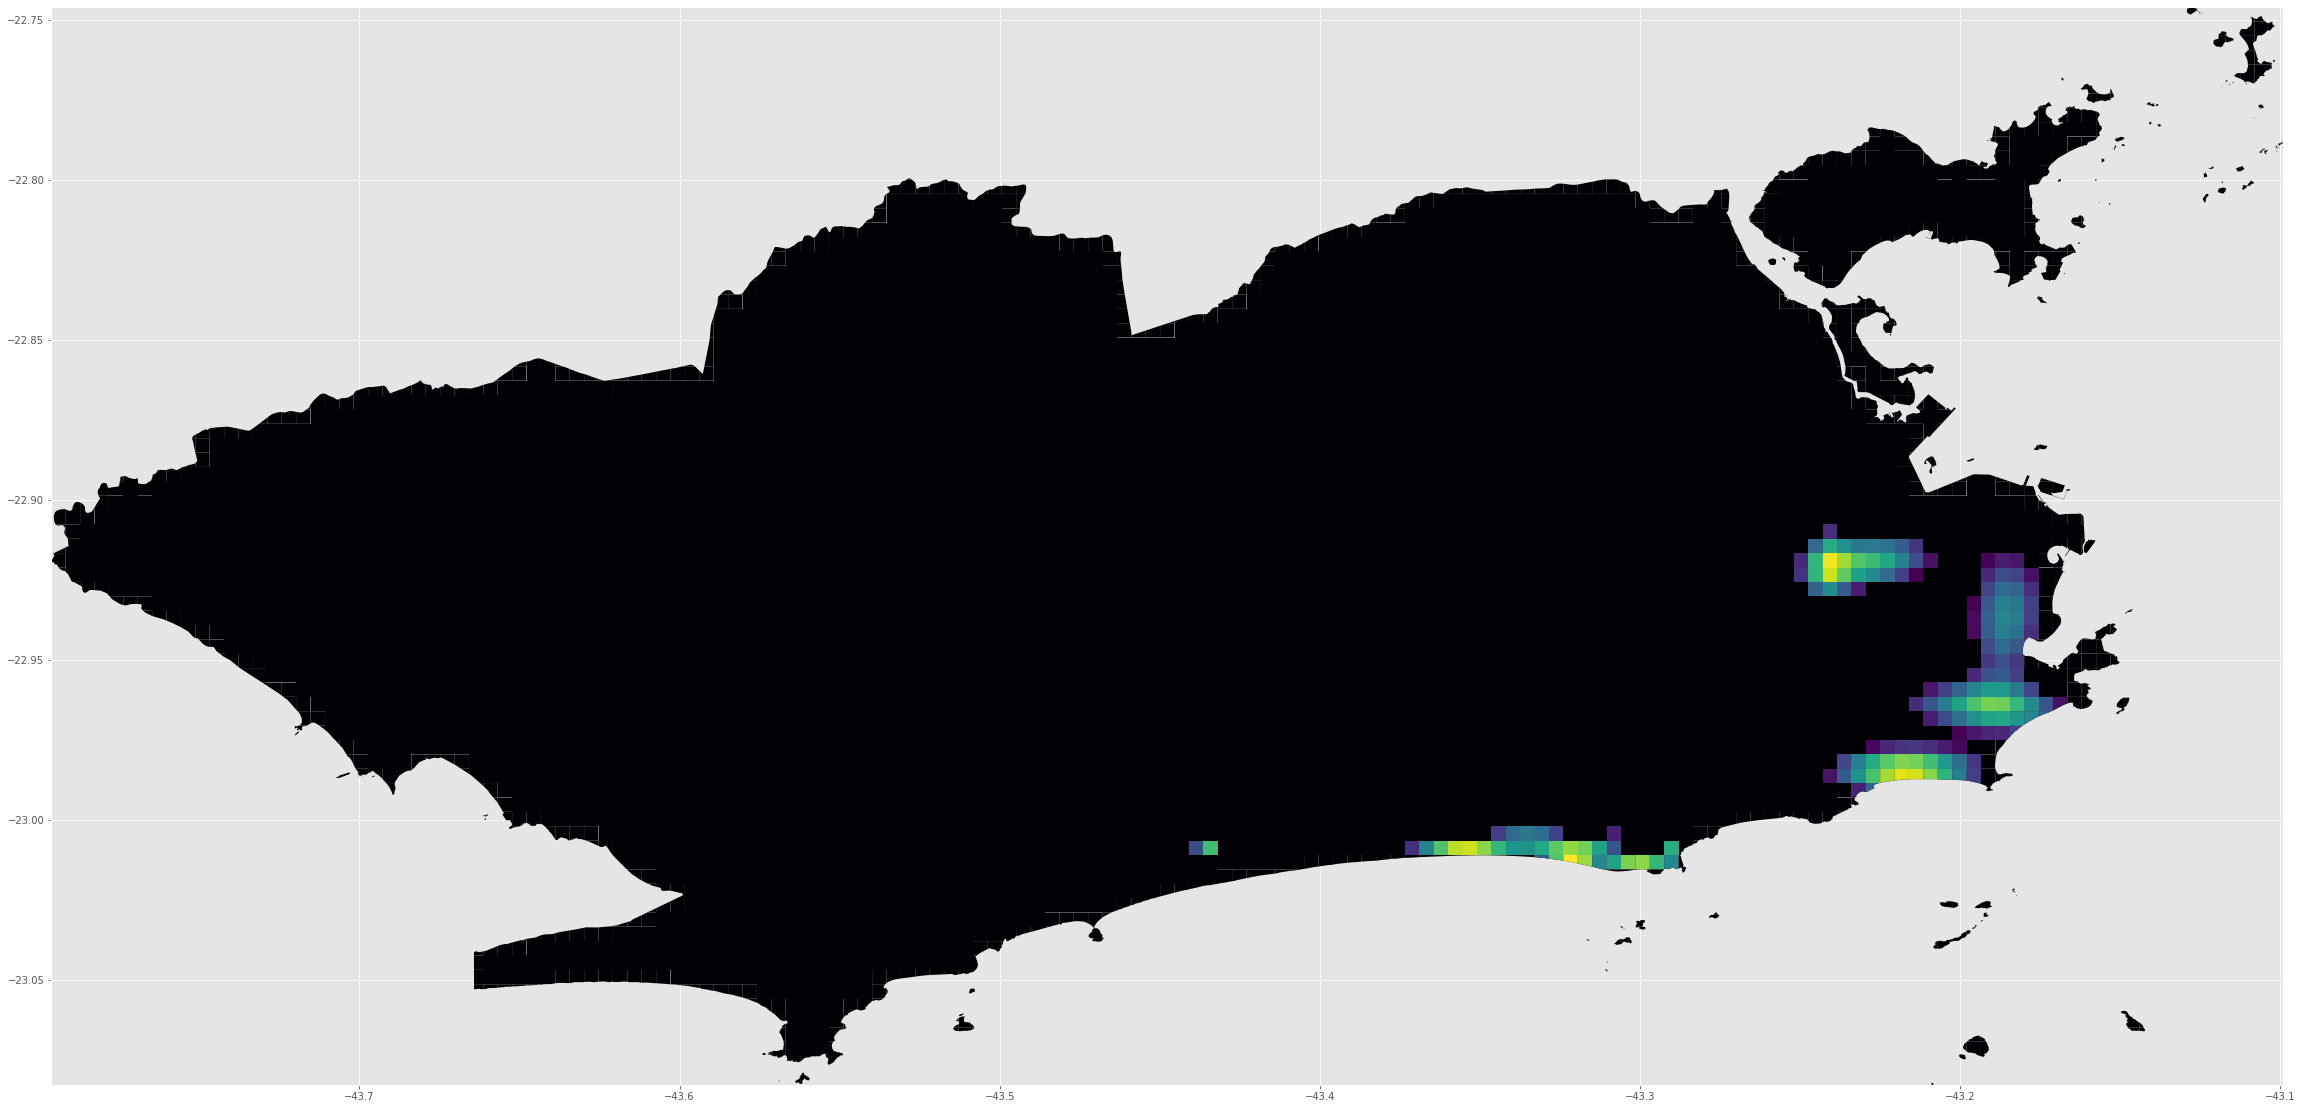

time: 2.44 s


In [49]:
# plot the city
west, south, east, north = city.unary_union.bounds
fig, ax = plt.subplots(figsize=(40,26))

polyframe.plot(ax=ax, color='#000004')
#polyair.plot(column='prices',  legend=True, cmap='magma', ax=ax)    
poly_prices[poly_prices.index.isin(loubar_keys)].plot(ax=ax, column='zpred')
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [50]:
pickle_in = open("City_spreading_index.pickle","rb")
spreading_index_dict = pickle.load(pickle_in)
#spreading_index_dict = {}
spreading_index_dict['Rio'] = eta_loubar


pickle_out = open("City_spreading_index.pickle","wb")
pickle.dump(spreading_index_dict, pickle_out)
pickle_out.close()

spreading_index_dict

{'Paris': 0.7251609142253275,
 'Amsterdam': 0.6513935879350918,
 'Stockholm': 0.6839327295656318,
 'Arezzo': 0.5574311537992848,
 'Berlin': 0.7499866909236614,
 'Bordeaux': 0.5818334466519048,
 'Denver': 0.6312111392217781,
 'Edinburgh': 0.6813298654934006,
 'Lyon': 0.6138305864151811,
 'Madrid': 0.6426066210787698,
 'Buenos_Aires': 0.8337988194080271,
 'Palermo': 0.8841435007903967,
 'Los_Angeles': 0.7889452782510832,
 'Beijing': 0.6425383574699105,
 'Florence': 0.5049117106731263,
 'Moscow': 0.6925493573699144,
 'Porto': 0.7058843952576399,
 'Prague': 0.5522963433539414,
 'Reykjavik': 0.8276260142343259,
 'Riga': 0.6850021296374689,
 'Rome': 0.5803964773671335,
 'Seoul': 0.8924742030382572,
 'Siena': 0.5646389917673048,
 'Sydney': 0.7909301400958108,
 'Tallin': 0.5690189423395199,
 'Treviso': 0.5345662066021125,
 'Valencia': 0.6956994914059091,
 'Venezia': 0.656650370883064,
 'Verona': 0.5707647012625697,
 'Vicenza': 0.5117751186840898,
 'Vienna': 0.6189242538490607,
 'Wellington': 0

time: 7.99 ms


eta =  1.0
eta =  1.0
eta =  1.0
eta =  0.99223169421996
eta =  0.9907957857245259
eta =  0.9613194561521574
eta =  0.9568374077127965
eta =  0.9688399875330552
eta =  0.9779807591518384
eta =  0.9690059816659153
eta =  0.9734489529125444
eta =  0.949277241350327
eta =  0.9582274170829741
eta =  0.9678935472453951
eta =  0.9692270943090168
eta =  0.9858134790363489
eta =  0.9762360132040118
eta =  0.9916600844047828
eta =  0.9859567008490446
eta =  0.973226843565951
eta =  0.9872386527968675
eta =  1.0039950006250822
eta =  1.0166377226848529
eta =  1.0334228738334814
eta =  1.0377064947231676
eta =  1.0573595668053302
eta =  1.0639874603538393
eta =  1.0852430061701261
eta =  1.065812043452478
eta =  1.0786494342464577
eta =  1.0871108565629368
eta =  1.097857032477225
eta =  1.0932312971018454
eta =  1.1120524816757116
eta =  1.0983952319245165
eta =  1.1106370720279384
eta =  1.1101234717917752
eta =  1.1227783437741312
eta =  1.1315958904161714
eta =  1.1497140541287012
eta =  1.14

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning:

Mean of empty slice.

C:\Users\gevor\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning:

invalid value encountered in double_scalars



eta =  nan



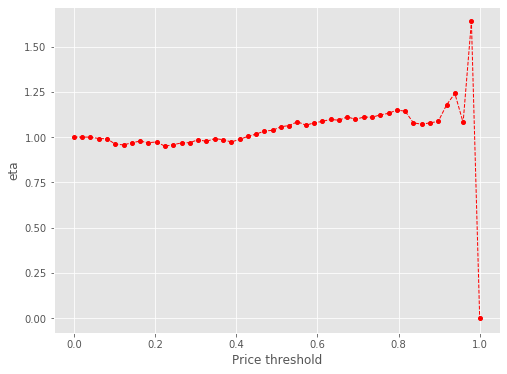

time: 766 ms


In [51]:
lval = np.linspace(min(vals_cut), max(vals_cut), 50)
etas = []
for i in tqdm_notebook(lval):
    loubar_keys = keys[vals_cut>=i]
    dist_mat = mat[keys.reshape(-1,1), keys]

    total_dist = dist_mat.sum()
    dist_corr = dist_mat[dist_mat>0]

    loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

    loubar_dist = loubar_dist_mat.sum()

    loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
    eta = loubar_dist_corr.mean()/dist_corr.mean()
    etas.append(eta)
    print('eta = ', eta)
etas = np.array(etas)
etas = np.where(np.isnan(etas), 0, etas)
lval = lval/lval.max()
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(lval, etas, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

In [52]:
pickle_in = open("etas_dict.pickle","rb")
etas_dict = pickle.load(pickle_in)
etas_dict['Rio'] = etas


pickle_out = open("etas_dict.pickle","wb")
pickle.dump(etas_dict, pickle_out)
pickle_out.close()

etas_dict

{'Paris': array([1.        , 1.        , 1.        , 1.        , 1.        ,
        0.99892229, 0.98804671, 0.97772318, 0.9741773 , 0.96402975,
        0.95612064, 0.94309786, 0.92621716, 0.90956978, 0.89431961,
        0.88163262, 0.86599252, 0.85303151, 0.83093605, 0.81937564,
        0.80452759, 0.79397664, 0.77891966, 0.76472821, 0.75139472,
        0.73760156, 0.72993045, 0.71599406, 0.6973232 , 0.68569382,
        0.66444837, 0.64913859, 0.63622062, 0.61622269, 0.60796744,
        0.59875293, 0.57553903, 0.55531623, 0.5196119 , 0.51294782,
        0.48889127, 0.47120143, 0.44129376, 0.4340038 , 0.42753283,
        0.28637398, 0.12703126, 0.11051098, 0.08187494, 0.        ]),
 'Amsterdam': array([1.        , 1.        , 1.        , 0.98445576, 0.94802335,
        0.92646326, 0.90668518, 0.87829204, 0.84903077, 0.8326123 ,
        0.81965488, 0.80699247, 0.78742068, 0.76382094, 0.74968915,
        0.73461255, 0.72510361, 0.71287238, 0.70839628, 0.69031358,
        0.65942466, 0.66

time: 36 ms


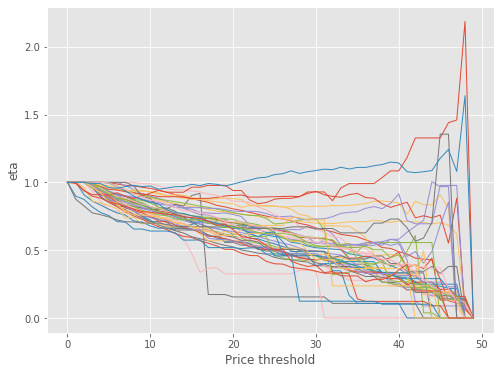

time: 298 ms


In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
for key in etas_dict:
    plt.plot(np.arange(50), etas_dict[key], linestyle='-', linewidth=1)
plt.xlabel("Price threshold")
plt.ylabel("eta")
plt.show()

In [ ]:
lorentz_vals = poly_prices.zpred.to_dict()
s = [(k, lorentz_vals[k]) for k in sorted(lorentz_vals, key=lorentz_vals.get)]
keys = []
vals = []
for k,v in s:
    keys.append(k)
    vals.append(v)
    

vals = np.array(vals)
#keys = np.array(keys)
keys_initial = np.array(keys)


perc_vals = np.linspace(0, 0.99, 100)
etas_2d = []
for i in tqdm_notebook(perc_vals):
    keys = keys_initial
    vals_cut = vals[vals>i*vals.max()]
    print(len(vals), len(vals_cut))

    L = np.cumsum(vals_cut)/np.sum(vals_cut)
    keys = keys[vals>i*vals.max()]
    print('Number of cells with price above {}th percentile: '.format(i*100), len(keys))
    etas = []
    lval = np.linspace(min(vals_cut), max(vals_cut), 100)
    for k in tqdm_notebook(lval):
        loubar_keys = keys[vals_cut>=k]
        dist_mat = mat[keys.reshape(-1,1), keys]

        total_dist = dist_mat.sum()
        dist_corr = dist_mat[dist_mat>0]

        loubar_dist_mat = mat[loubar_keys.reshape(-1,1), loubar_keys]

        loubar_dist = loubar_dist_mat.sum()

        loubar_dist_corr = loubar_dist_mat[loubar_dist_mat>0]
        eta = loubar_dist_corr.mean()/dist_corr.mean()
        etas.append(eta)
        print('eta = ', eta)
    etas_array = np.array(etas)
    etas_array = np.where(np.isnan(etas_array), 0, etas_array)
    lval = (lval - lval.min())/(lval - lval.min()).max()
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(lval, etas_array, color='r', linestyle='--', marker='o', markersize=4, linewidth=1)
    plt.xlabel("Price threshold")
    plt.ylabel("eta")
    plt.show()
    etas_2d.append(etas)
etas_2d = np.array(etas_2d)
etas_2d = np.where(np.isnan(etas_2d), 0, etas_2d)
lval = lval/lval.max()

5942 5942
Number of cells with price above 0.0th percentile:  5942


eta =  1.0
eta =  0.35503313639602047
eta =  0.3529823048473639
eta =  0.3507605422235463
eta =  0.34652798875757196
eta =  0.3448945913800885
eta =  0.34221534473236603
eta =  0.3438581330302892
eta =  0.3413857324037304
eta =  0.33964356405289303
eta =  0.3315538810153272
eta =  0.3325894768715772
eta =  0.3296253785346169
eta =  0.33092193533869246
eta =  0.3338734612006645
eta =  0.3357369658327039
eta =  0.3373311955090093
eta =  0.3352559160114896
eta =  0.3342323875402715
eta =  0.3319415011945512
eta =  0.3357018981366398
eta =  0.3272744105263106
eta =  0.32685537510805657
eta =  0.32825160256534175
eta =  0.33048745346402997
eta =  0.3305919781105204
eta =  0.33252082511886555


total number of cells:  5942
number of cells within urban airbnb territory:  467



Mean travel times in minutes:  11.925404006295869
Mean travel times in minutes:  19.954739114917913
Mean travel times in minutes:  31.65372410732261
Mean travel times in minutes:  44.181184245685316
Mean travel times in minutes:  55.638851918958984
Mean travel times in minutes:  68.56767541499661
Mean travel times in minutes:  76.73517810538259
Mean travel times in minutes:  90.37082231556215
Mean travel times in minutes:  126.75649922216732


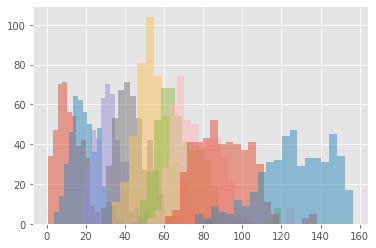

time: 15min 27s


In [54]:
from tqdm import tqdm_notebook
print('total number of cells: ', len(polylist))

times_names = ['times_{}'.format(c) for c in range(1, len(centers)+1)]
times_dict = {name:[] for name in times_names}

plist = poly_prices[poly_prices.index.isin(keys)].geometry.tolist()
print('number of cells within urban airbnb territory: ', len(plist))
for poly in tqdm_notebook(plist):
    origin = ox.get_nearest_node(G, poly.centroid.coords[0][::-1])
    dists_to_centers = []
    for node, target in centers.items():
        try:
            if origin!=target:
                path = nx.shortest_path(G, origin, target, weight='length')
                edges = [ tuple( path[i:i+2] ) for i in range( len(path) - 1 ) ]
                dist = np.sum([G.get_edge_data(*edge)[0]['length'] for edge in edges])
                dists_to_centers.append(dist)
        except:
            pass
    if len(dists_to_centers) != 0:
        dists_to_centers = sorted(dists_to_centers)
        #print('distance list length equal to # of centers: ', len(dists_to_centers)==len(centers))
        if len(dists_to_centers)==len(centers):
            for n, dist in enumerate(dists_to_centers):
                time = (dist/3.9)/60
                times_dict['times_{}'.format(n+1)].append(time)
                #print(times_dict['times_{}'.format(n+1)][-1])
        else:
            print('Distance list length NOT equal to # of centers')

#print(distances_dict)
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=0.5)
plt.show()

Mean travel times in minutes:  11.925404006295869
Mean travel times in minutes:  19.954739114917913
Mean travel times in minutes:  31.65372410732261
Mean travel times in minutes:  44.181184245685316
Mean travel times in minutes:  55.638851918958984
Mean travel times in minutes:  68.56767541499661
Mean travel times in minutes:  76.73517810538259
Mean travel times in minutes:  90.37082231556215
Mean travel times in minutes:  126.75649922216732


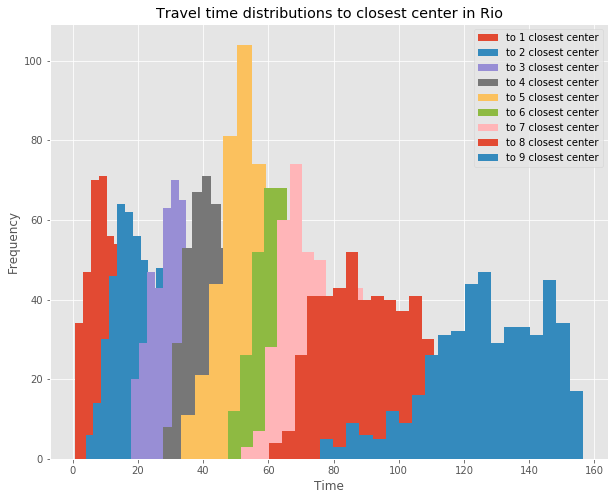

time: 894 ms


In [55]:
for center in range(1, len(centers)+1):
    times_dict['times_{}'.format(center)] = np.array(times_dict['times_{}'.format(center)])
    
for center in range(1, len(centers)+1):
    print("Mean travel times in minutes: ", np.mean(times_dict['times_{}'.format(center)]))

fig, ax = plt.subplots(figsize=(10,8))
for center in range(1, len(centers)+1):
    plt.hist(times_dict['times_{}'.format(center)], bins=20, alpha=1, label='to {} closest center'.format(center))
plt.title('Travel time distributions to closest center in Rio')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [56]:
pickle_in = open("City_Accessibility.pickle","rb")
access_dict = pickle.load(pickle_in)
#access_dict = {}
access_dict['Rio'] = times_dict


pickle_out = open("City_Accessibility.pickle","wb")
pickle.dump(access_dict, pickle_out)
pickle_out.close()

access_dict

{'Paris': {'times_1': array([ 4.73219737,  4.40047807,  7.81577632,  7.07926754,  6.7129386 ,
          7.48037281, 10.85755263,  8.41227193, 14.20045614, 15.15502193,
         16.00692982, 15.80582895, 14.35941228, 14.10681579, 12.26687281,
         13.89203947, 14.31310965, 15.99389474, 16.77728947, 17.82112281,
         20.19769737, 20.40849561, 21.93033333, 22.03087719, 20.6584386 ,
         20.62538596, 19.53197368, 20.61141228, 21.70609211, 23.22407018,
         21.70395614, 23.12607456, 22.79396053, 23.95434211, 21.49400439,
         21.55605702, 22.35374123, 22.36948246, 22.44162719, 21.54410965,
         21.93589912, 21.86757456, 21.86757456, 21.41060088, 21.92571491,
         22.93862281, 23.57200877, 25.13889474, 24.49192982, 26.04400877,
         26.815     , 38.90660088, 38.56507018, 37.89241228, 36.57546491,
         29.87379386, 27.54254825, 25.54755702, 26.98263158, 25.76562281,
         25.03485526, 25.37799123, 25.69687719, 26.07382018, 23.81846491,
         24.034649

time: 507 ms


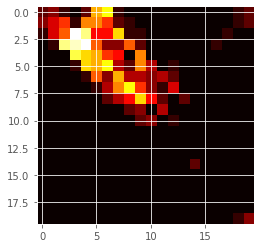

time: 172 ms


In [57]:
x = times_dict['times_{}'.format(1)]
y = times_dict['times_{}'.format(2)]
c_xy = np.histogram2d(x, y, 20)[0]
c_xx = np.histogram2d(x, x, 20)[0]
plt.imshow(c_xy, cmap='hot', interpolation='nearest')
plt.show()

In [60]:
from sklearn.metrics import mutual_info_score

def calc_MI(x, y, bins):
    c_xy = np.histogram2d(x, y, bins)[0]
    mi = mutual_info_score(None, None, contingency=c_xy)
    return mi

mi_list = []
for center in range(1, len(centers)+1):
    mi_list.append(times_dict['times_{}'.format(center)])

mis = []
for pair in combinations_with_replacement(mi_list, 2):
    MI = calc_MI(pair[0], pair[1], 20)
    print(MI)
    mis.append(MI)
mis = np.array(mis)
avg_mi = np.mean(mis)
print('average mutual information = ', avg_mi)

2.3038757372434255
0.617882460204241
0.3194272952944664
0.2684583655245911
0.3916463044071869
0.6038454903991493
0.44055898844675945
0.4758306662771574
0.41646697434563856
2.494224726578243
0.5715960466294915
0.4277457412482939
0.4813646168984455
0.48244302078138857
0.6453562014265035
0.6669530821608991
0.6574037530135525
2.425762185909555
0.5555387478328668
0.4827097258462601
0.4975989892136009
0.47688856010998976
0.49867163532575015
0.8617473185240025
2.350048916929903
0.6826899404597704
0.4487203147975689
0.460867696033168
0.5684804521852497
0.6615222699440909
2.2036163251269274
0.665018691859027
0.5322860884856943
0.641054131764031
0.7395426750986906
2.4478737693687225
1.0459778370434636
0.9037881606750942
0.8488147891683157
2.4317506919629888
1.4788708319477581
1.0015779510456588
2.598970670313582
1.1946397320859619
2.7895081952876812
average mutual information =  0.9946581503383292
time: 126 ms


In [59]:
pickle_in = open("Time_distribution_mutual_information.pickle","rb")
MI_dict = pickle.load(pickle_in)
#MI_dict = {}
MI_dict['Rio'] = avg_mi


pickle_out = open("Time_distribution_mutual_information.pickle","wb")
pickle.dump(MI_dict, pickle_out)
pickle_out.close()

MI_dict

{'Beijing': 1.6170682943522052,
 'Florence': 2.0836399429599792,
 'Palermo': 1.8596013030930105,
 'Los_Angeles': 1.5602500680599918,
 'Moscow': 1.5631970905638934,
 'Porto': 1.6277816420571996,
 'Prague': 2.176480497902222,
 'Reykjavik': 1.3730161847793374,
 'Riga': 2.240374487910287,
 'Rome': 1.6095563575725969,
 'Seoul': 1.2910685865906735,
 'Siena': 2.7660068415344448,
 'Sydney': 1.2791891753795948,
 'Tallin': 2.3884073435187867,
 'Treviso': 2.631909071373147,
 'Valencia': 2.1872520197930965,
 'Venezia': 2.719891808939249,
 'Verona': 2.7080241467515376,
 'Vicenza': 2.6192607829416756,
 'Vienna': 1.4481542925032476,
 'Wellington': 2.1855226822614866,
 'Zurich': 2.462051055806955,
 'Aarhus': 2.2910468431831847,
 'Milan': 1.6107461389394335,
 'Busan': 1.903641833377143,
 'Barcelona': 1.6449937230537024,
 'Bologna': 2.7317991260148045,
 'Bremen': 1.9447717965210316,
 'Brno': 2.4300669174144036,
 'Budapest': 2.219525897631017,
 'Dublin': 1.830502368836079,
 'Boston': 1.1451275682586615,


time: 6 ms
